In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
import os
import time

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

import matplotlib.pyplot as plt
%matplotlib inline

Setting environment for Gordon


No vtk


In [4]:
import numdifftools as nd

# 1. Compute Confidence for Global Transform

In [5]:
warp_setting = 1    
classifier_setting = 2

In [6]:
stack_moving = 'atlasV2'

In [24]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_score_volume_all_known_structures(stack=stack_moving, sided=True)

File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/atlasV2/atlasV2_down32_scoreVolume/score_volumes/atlasV2_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist.
File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/atlasV2/atlasV2_down32_scoreVolume/score_volumes/atlasV2_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist.


# All Stacks

In [ ]:
for stack_fixed in all_nissl_stacks:
# for stack_fixed in ['MD595']:

    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
    DataManager.load_score_volume_all_known_structures(stack=stack_fixed, classifier_setting=classifier_setting)
    
    label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                         for label_m, name_m in label_to_structure_moving.iteritems()}
                        #     if name_m in ['7N_L', '7N_R', '12N', '5N_L', '5N_R']}
    
    aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)
    
    aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
    # aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', indices_m=[name_to_label_moving['SNR_R']])
    
    tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
        DataManager.load_alignment_parameters(stack_f=stack_fixed, stack_m=stack_moving,
                                              classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting, 
                                              warp_setting=warp_setting,
                                              downscale=32, trial_idx=trial_idx)
        
    ###############################
    ##### Compute Confidence ######
    ###############################

#     structures_for_computing_confidence = {'7N_L', '7N_R', '5N_L', '5N_R', '12N'}
#     labels_for_computing_confidence = [structure_to_label_moving[s] for s in structures_for_computing_confidence]
    labels_for_computing_confidence = label_to_structure_moving.keys()

    downscale = 32
    xy_pixel_distance = XY_PIXEL_DISTANCE_LOSSLESS * downscale

    fmax = aligner.compute_score(tx_params, indices_m=labels_for_computing_confidence)
    
    ######################
    ## Compute Hessians ##
    ######################
    
    def perturb(tx, ty, tz):
        return aligner.compute_score(tx_params + [0,0,0,tx,0,0,0,ty,0,0,0,tz],
                                 indices_m=labels_for_computing_confidence)

    hessians_all_stepsizes = {}
    stepsizes = np.linspace(1, 20, 5) # pixel size = 15um

    for stepsize in stepsizes:
        h = nd.Hessian(lambda (tx, ty, tz): perturb(tx, ty, tz), step=(stepsize, stepsize, stepsize))
        H = h((0,0,0))
        stepsize_um = stepsize * xy_pixel_distance
        hessians_all_stepsizes[stepsize_um] = (H, fmax)
        
    ##################
    ## Save hessian ##
    ##################

    fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed, 
                                       classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                       warp_setting=warp_setting, trial_idx=trial_idx,
                                       what='hessians')

    create_if_not_exists(os.path.dirname(fp))
    save_pickle(hessians_all_stepsizes, fp)
    
    #####################
    ## Compute z-score ##
    #####################
    
    zscores = {}

    # pool_radius_um_list = np.arange(25, 400, 20)
    pool_radius_um_list = np.linspace(25, 400, 5)
    for pool_radius_um in pool_radius_um_list:

        pool_radius_pixel = pool_radius_um / xy_pixel_distance

        t = time.time()

    #     grid_size = 3
    #     dxs = np.arange(-pooling_radius, pooling_radius, grid_size)
    #     dys = np.arange(-pooling_radius, pooling_radius, grid_size)
    #     dzs = np.arange(-pooling_radius, pooling_radius, grid_size)
    #     neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, dxs=dxs, dys=dys, dzs=dzs,
    #                                                                indices_m=labels_for_computing_confidence)

        neighbor_scores = aligner.compute_scores_neighborhood_random(tx_params, n=3000, 
                        stds=np.array([0,0,0,pool_radius_pixel,0,0,0,pool_radius_pixel,0,0,0,pool_radius_pixel]), 
                        indices_m=labels_for_computing_confidence)

        sys.stderr.write('Compute scores: %.2f seconds.\n' % (time.time() - t))

        mean = np.mean(neighbor_scores)
        std = np.std(neighbor_scores)
        z = (fmax - mean) / std

        zscores[pool_radius_um] = (z, fmax, mean, std)
        

    ###################
    ## Save z-scores ##
    ###################

    fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed, 
                                       classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                       warp_setting=warp_setting, trial_idx=trial_idx,
                                       what='zscores')

    create_if_not_exists(os.path.dirname(fp))
    save_pickle(zscores, fp)

File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD585/score_volumes/MD585_down32_scoreVolume_outerContour_setting_2.bp
Score volume for outerContour does not exist.
File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD585/score_volumes/MD585_down32_scoreVolume_sp5_setting_2.bp
Score volume for sp5 does not exist.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Compute scores: 128.39 seconds.
Compute scores: 112.88 seconds.
Compute scores: 117.98 seconds.
Compute scores: 112.54 seconds.
Compute scores: 114.21 seconds.
File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD589/score_volumes/MD589_down32_scoreVolume_outerContour_setting_2.bp
Score volume for outerContour does not exist.
File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD589/score_volumes/MD589_down32_scoreVolume_sp5_setting_2.bp
Score volume for sp5 does not exist.
Label weights not set, default

# ONE Stack

In [25]:
stack_fixed = 'MD595'

# Load Fixed Volumes

In [26]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_score_volume_all_known_structures(stack=stack_fixed, classifier_setting=classifier_setting)

label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                     for label_m, name_m in label_to_structure_moving.iteritems()}
                    #     if name_m in ['7N_L', '7N_R', '12N', '5N_L', '5N_R']}

File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD595/MD595_down32_scoreVolume_clf_2/score_volumes/MD595_down32_scoreVolume_clf_2_outerContour.bp
Score volume for outerContour does not exist.
File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD595/MD595_down32_scoreVolume_clf_2/score_volumes/MD595_down32_scoreVolume_clf_2_sp5.bp
Score volume for sp5 does not exist.


In [ ]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')

# Read Global Transform Estimate

In [12]:
tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
DataManager.load_alignment_parameters(stack_f=stack_fixed, stack_m=stack_moving,
                                      classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting, 
                                      warp_setting=warp_setting,
                                      type_f='score', type_m='score',
                                      downscale=32, trial_idx=trial_idx)

In [13]:
structures_for_computing_confidence = {'7N_L', '7N_R', '5N_L', '5N_R', '12N'}
labels_for_computing_confidence = [structure_to_label_moving[s] for s in structures_for_computing_confidence]
# labels_for_computing_confidence = label_to_structure_moving.keys()

downscale = 32
xy_pixel_distance = XY_PIXEL_DISTANCE_LOSSLESS * downscale

fmax = aligner.compute_score(tx_params, indices_m=labels_for_computing_confidence)

# Optimize

In [51]:
# gradient_filepath_map_f = {ind_f: DataManager.get_score_volume_gradient_filepath_template(\
#                             stack=stack_fixed, structure=label_to_structure_fixed[ind_f],
#                             downscale=32, setting=classifier_setting)
#                            for ind_m, ind_f in label_mapping_m2f.iteritems()}

# aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s = 2 mins

# while True:

#     try:

#         if global_transform_scheme == 1:

#             T, scores = aligner.optimize(type='affine', max_iter_num=1000, history_len=10, terminate_thresh=1e-4,
# #                                          indices_m=[name_to_label_moving['SC'], name_to_label_moving['IC'],
# #                                                    name_to_label_moving['SC_surround'], name_to_label_moving['IC_surround']],
#                                          indices_m=None,
#                                         grid_search_iteration_number=30,
#                                          grid_search_sample_number=100,
#                                          grad_computation_sample_number=1e5,
#                                          lr1=10, lr2=0.1,
#                                         std_tx=50, std_ty=50, std_tz=100, std_theta_xy=np.deg2rad(10))

#         elif global_transform_scheme == 2:

#             T, scores = aligner.optimize(type='rigid', max_iter_num=1000, history_len=10, terminate_thresh=1e-4,
#                                          indices_m=None,
#                                         grid_search_iteration_number=30,
#                                          grid_search_sample_number=100,
#                                          grad_computation_sample_number=1e5,
#                                          lr1=10, lr2=0.1,
#                                         std_tx=50, std_ty=50, std_tz=100, std_theta_xy=np.deg2rad(10))
        
#         break
        
#     except Exception as e:
#         sys.stderr.write(e.message + '\n')

# Compute Hessian

In [14]:
def perturb(tx, ty, tz):
    return aligner.compute_score(tx_params + [0,0,0,tx,0,0,0,ty,0,0,0,tz],
                                 indices_m=labels_for_computing_confidence)

hessians_all_stepsizes = {}
stepsizes = np.linspace(1, 20, 5) # pixel size = 15um

for stepsize in stepsizes:
    h = nd.Hessian(lambda (tx, ty, tz): perturb(tx, ty, tz), step=(stepsize, stepsize, stepsize))
    H = h((0,0,0))
    stepsize_um = stepsize * xy_pixel_distance
    hessians_all_stepsizes[stepsize_um] = (H, fmax)

In [67]:
# Save hessian

fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed, 
                                         type_m='score', type_f='score',
                                         classifier_setting_m=classifier_setting, 
                                         classifier_setting_f=classifier_setting,
                                         warp_setting=warp_setting, trial_idx=trial_idx,
                                         what='hessians')

create_if_not_exists(os.path.dirname(fp))
save_pickle(hessians_all_stepsizes, fp)

# Compute z-score

In [15]:
zscores = {}

# pool_radius_um_list = np.arange(25, 400, 20)
pool_radius_um_list = np.linspace(25, 400, 5)
for pool_radius_um in pool_radius_um_list:
    
    pool_radius_pixel = pool_radius_um / xy_pixel_distance

    t = time.time()
    
#     grid_size = 3
#     dxs = np.arange(-pooling_radius, pooling_radius, grid_size)
#     dys = np.arange(-pooling_radius, pooling_radius, grid_size)
#     dzs = np.arange(-pooling_radius, pooling_radius, grid_size)
#     neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, dxs=dxs, dys=dys, dzs=dzs,
#                                                                indices_m=labels_for_computing_confidence)
    
    neighbor_scores = aligner.compute_scores_neighborhood_random(tx_params, n=3000, 
                    stds=np.array([0,0,0,pool_radius_pixel,0,0,0,pool_radius_pixel,0,0,0,pool_radius_pixel]), 
                    indices_m=labels_for_computing_confidence)
    
    sys.stderr.write('Compute scores: %.2f seconds.\n' % (time.time() - t))
    
    mean = np.mean(neighbor_scores)
    std = np.std(neighbor_scores)
    z = (fmax - mean) / std
    
    zscores[pool_radius_um] = (z, fmax, mean, std)

Compute scores: 4.67 seconds.
Compute scores: 4.48 seconds.
Compute scores: 4.60 seconds.
Compute scores: 4.60 seconds.
Compute scores: 4.61 seconds.


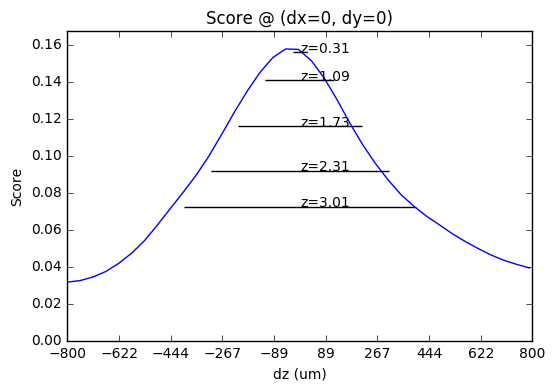

In [16]:
max_pooling_radius_um = 800
max_pooling_radius_pixel = max_pooling_radius_um / xy_pixel_distance

grid_size = 3
dzs = np.arange(-max_pooling_radius_pixel, max_pooling_radius_pixel, grid_size)
neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, dxs=[0], dys=[0], dzs=dzs,
                                                           indices_m=labels_for_computing_confidence)

plt.plot(dzs * xy_pixel_distance, neighbor_scores)
plt.ylim([0, np.max(neighbor_scores) + .01]);
plt.xlim([-max_pooling_radius_um, max_pooling_radius_um]);
plt.title('Score @ (dx=0, dy=0)')
plt.ylabel('Score');
plt.xlabel('dz (um)');
plt.xticks(np.linspace(-max_pooling_radius_um, max_pooling_radius_um, 10));

for poolradius_um, (z, fmax, mean, std) in zscores.iteritems():
    plt.hlines(mean, -poolradius_um, poolradius_um);
    plt.text(x=0, y=mean, s='z=%.2f'%z)

plt.show();

In [66]:
# Save z-scores

fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed, 
                                    type_m='score', type_f='score',
                                   classifier_setting_m=classifier_setting, 
                                         classifier_setting_f=classifier_setting,
                                   warp_setting=warp_setting, trial_idx=trial_idx,
                                   what='zscores')

create_if_not_exists(os.path.dirname(fp))
save_pickle(zscores, fp)

# Read previously computed confidence metrics; Compute Peak Radius

In [152]:
stack_moving = 'atlasV2'
stack_fixed = 'MD592'

In [153]:
classifier_setting = 2
warp_setting = 1
trial_idx = 0

In [154]:
downscale = 32
xy_pixel_distance = XY_PIXEL_DISTANCE_LOSSLESS * downscale

In [155]:
from collections import defaultdict

In [ ]:
peak_radius_all_stacks = defaultdict(list)

for stack_fixed in all_nissl_stacks:
    
    # Load previously computed confidence measures

    zscores = DataManager.load_confidence(stack_m=stack_moving, stack_f=stack_fixed, 
                                       classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                       warp_setting=warp_setting, trial_idx=trial_idx,
                                       what='zscores')

    hessians_all_stepsizes = DataManager.load_confidence(stack_m=stack_moving, stack_f=stack_fixed, 
                                       classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                       warp_setting=warp_setting, trial_idx=trial_idx,
                                       what='hessians')
    
    peak_radius = defaultdict(dict)
    for poolradius_um, (zscore, fmax, mu, std) in zscores.iteritems():
        for stepsize_um, (H, fmax) in hessians_all_stepsizes.iteritems():
            if poolradius_um > stepsize_um * 2:  # compute only if pooling radius is at least twice the step size
                U, S, UT = np.linalg.svd(H)

                # using the smallest eigenvalues of Hessians (flattest direction), drop to mean
                peak_radius_pixel_max = np.sqrt(2*(fmax-mu)/S[-1])

                # using the largest eigenvalues of Hessians (steepest direction), drop to mean
                peak_radius_pixel_min = np.sqrt(2*(fmax-mu)/S[0])

                # using the largest eigenvalues of Hessians, drop to 2-sigma
    #             peak_radius_pixel = np.sqrt(2*(fmax-(mu+2*std))/S[0])

                peak_radius[poolradius_um][stepsize_um] = (peak_radius_pixel_max * xy_pixel_distance,
                                                          peak_radius_pixel_min * xy_pixel_distance)
    peak_radius.default_factory = None

    # Plot

    for poolradius_um, v in peak_radius.iteritems():
        xs, ys_max_min = zip(*sorted(v.items()))
        ys_max, ys_min = zip(*ys_max_min)
    #     c = np.array(high_contrast_colors[np.random.randint(0, len(high_contrast_colors))])/255.
        c = np.array(random_colors(1)[0])/255.
        plt.plot(xs, ys_max, linestyle='-', color=c, label='pool=%dum, max' % poolradius_um);
        plt.plot(xs, ys_min, linestyle='--', color=c, label='pool=%dum, min' % poolradius_um);
        print xs, ys_min
    # plt.legend(loc='lower right');
    # plt.title('Peak radius');
    plt.xlabel('Hessian step size (um)');
    plt.ylabel('Peak radius (um)');
    plt.show();

# Load all stacks

In [12]:
stack_moving = 'atlasV2'

zscores_all_stacks = {}
hessians_all_stacks_all_stepsizes = {}

for stack_fixed in all_nissl_stacks:

    zscores = DataManager.load_confidence(stack_m=stack_moving, stack_f=stack_fixed, 
                                       classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                       warp_setting=warp_setting, trial_idx=trial_idx,
                                       what='zscores')

    hessians_all_stepsizes = DataManager.load_confidence(stack_m=stack_moving, stack_f=stack_fixed, 
                                       classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                       warp_setting=warp_setting, trial_idx=trial_idx,
                                       what='hessians')
    
    zscores_all_stacks[stack_fixed] = zscores
    hessians_all_stacks_all_stepsizes[stack_fixed] = hessians_all_stepsizes

In [13]:
pool_radius_list = sorted(zscores_all_stacks.values()[0].keys())

In [14]:
pool_radius = pool_radius_list[1]
print pool_radius

118.75


In [15]:
zscore_toplot_all_stacks = {st: zs[pool_radius][0] for st, zs in zscores_all_stacks.iteritems()}

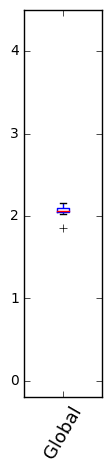

In [36]:
plt.figure(figsize=(1, 5));
D = [zscore_toplot_all_stacks.values()]
plt.boxplot(D);
plt.ylim([-.2,4.5]);
plt.xticks(range(1, 2), ['Global'], rotation='60', fontsize=13);

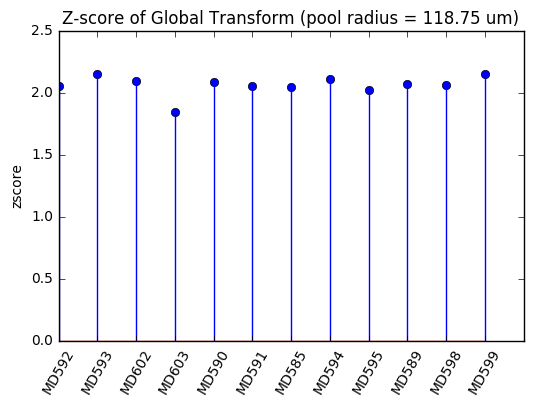

In [16]:
plt.stem(zscore_toplot_all_stacks.values());
plt.xticks(range(len(zscore_toplot_all_stacks)), zscore_toplot_all_stacks.keys(), rotation='60');
plt.title('Z-score of Global Transform (pool radius = %.2f um)' % pool_radius);
plt.ylabel('zscore');

# 2. Compute Confidence for Local Transforms

In [94]:
warp_setting = 5
classifier_setting = 2

In [95]:
if warp_setting == 1:
    upstream_warp_setting = None    
    transform_type = 'affine'
elif warp_setting == 2:
    upstream_warp_setting = 1
    transform_type = 'rigid'
    include_surround = False
elif warp_setting == 4:
    upstream_warp_setting = 1
    transform_type = 'rigid'
    reg_weights = np.array([1e-6, 1e-6, 1e-6])
    include_surround = False
elif warp_setting == 5:
    upstream_warp_setting = 1
    transform_type = 'rigid'
    reg_weights = np.array([0,0,0])
    include_surround = True
else:
    raise Exception('Warp setting not recognized.')

In [96]:
trial_idx = 0

if trial_idx in [0, 1]:
    upstream_trial_idx = 0

In [97]:
# stack_fixed = 'MD602'
stack_moving = 'atlasV2'

In [99]:
surround_weight = 0

In [100]:
# for stack_fixed in all_nissl_stacks:
for stack_fixed in ['MD602']:

    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
    DataManager.load_score_volume_all_known_structures(stack=stack_fixed, classifier_setting=classifier_setting)


    for structure in all_known_structures_sided:
    # for structure in ['7N_L']:

        try:

            if include_surround:
                volume_moving = DataManager.load_transformed_volume_all_known_structures(stack_m=stack_moving, stack_f=stack_fixed,
                                                                             classifier_setting_m=classifier_setting,
                                                                             classifier_setting_f=classifier_setting,
                                                                             warp_setting=upstream_warp_setting, 
                                                                             trial_idx=upstream_trial_idx,
                                                                             structures=[structure, 
                                                                                         convert_to_surround_name(structure, margin='x1.5')])
            else:
                volume_moving = DataManager.load_transformed_volume_all_known_structures(stack_m=stack_moving, stack_f=stack_fixed,
                                                                             classifier_setting_m=classifier_setting,
                                                                             classifier_setting_f=classifier_setting,
                                                                             warp_setting=upstream_warp_setting, 
                                                                             trial_idx=upstream_trial_idx,
                                                                             structures=[structure])

            structure_to_label_moving = {s: l+1 for l, s in enumerate(sorted(volume_moving.keys()))}
            label_to_structure_moving = {l+1: s for l, s in enumerate(sorted(volume_moving.keys()))}
            volume_moving = {structure_to_label_moving[s]: v for s, v in volume_moving.items()}

            label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                                 for label_m, name_m in label_to_structure_moving.iteritems()}

            label_weights_m = {label_m: surround_weight if 'surround' in name_m else 1. \
                               for label_m, name_m in label_to_structure_moving.iteritems()}


            aligner = Aligner4(volume_fixed, volume_moving, 
                               labelIndexMap_m2f=label_mapping_m2f)

            aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', 
                                 indices_m=[structure_to_label_moving[structure]])                            

            aligner.set_regularization_weights(reg_weights)
            aligner.set_label_weights(label_weights_m)

            ########################################
            # Read previous computed best estimate #
            ########################################

            tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
            DataManager.load_alignment_parameters(stack_m=stack_moving, stack_f=stack_fixed,
                                                  classifier_setting_m=classifier_setting,
                                                  classifier_setting_f=classifier_setting,
                                                  warp_setting=warp_setting,
                                                  param_suffix=structure,
                                                  trial_idx=trial_idx)


    #         structures_for_computing_confidence = {'7N_L', '7N_R', '5N_L', '5N_R', '12N'}
    #         labels_for_computing_confidence = [structure_to_label_moving[s] for s in structures_for_computing_confidence]
    #         labels_for_computing_confidence = label_to_structure_moving.keys()

            labels_for_computing_confidence = [structure_to_label_moving[structure]]

            downscale = 32
            xy_pixel_distance = XY_PIXEL_DISTANCE_LOSSLESS * downscale

            fmax = aligner.compute_score(tx_params, indices_m=labels_for_computing_confidence)

            ####################
            # Compute Hessians #
            ####################

            def perturb(tx, ty, tz):
                return aligner.compute_score(tx_params + [0,0,0,tx,0,0,0,ty,0,0,0,tz],
                                             indices_m=labels_for_computing_confidence)

            hessians_all_stepsizes = {}
            stepsizes = np.linspace(1, 20, 5) # pixel size = 15um

            for stepsize in stepsizes:
                h = nd.Hessian(lambda (tx, ty, tz): perturb(tx, ty, tz), step=(stepsize, stepsize, stepsize))
                H = h((0,0,0))
                stepsize_um = stepsize * xy_pixel_distance
                hessians_all_stepsizes[stepsize_um] = (H, fmax)


            #################
            # Save hessians #
            #################

            fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                       classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                       warp_setting=warp_setting, trial_idx=trial_idx,
                                                     param_suffix=structure,
                                       what='hessians')

            create_if_not_exists(os.path.dirname(fp))
            save_pickle(hessians_all_stepsizes, fp)

            ###################
            # Compute z-score #
            ###################

            zscores = {}

            # pool_radius_um_list = np.arange(25, 400, 20)
            pool_radius_um_list = np.linspace(25, 400, 5)
            for pool_radius_um in pool_radius_um_list:

                pool_radius_pixel = pool_radius_um / xy_pixel_distance

                t = time.time()

            #     grid_size = 3
            #     dxs = np.arange(-pooling_radius, pooling_radius, grid_size)
            #     dys = np.arange(-pooling_radius, pooling_radius, grid_size)
            #     dzs = np.arange(-pooling_radius, pooling_radius, grid_size)
            #     neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, dxs=dxs, dys=dys, dzs=dzs,
            #                                                                indices_m=labels_for_computing_confidence)

                neighbor_scores = aligner.compute_scores_neighborhood_random(tx_params, n=3000, 
                                stds=np.array([0,0,0,pool_radius_pixel,0,0,0,pool_radius_pixel,0,0,0,pool_radius_pixel]), 
                                indices_m=labels_for_computing_confidence)

                sys.stderr.write('Compute scores: %.2f seconds.\n' % (time.time() - t))

                mean = np.mean(neighbor_scores)
                std = np.std(neighbor_scores)
                z = (fmax - mean) / std

                zscores[pool_radius_um] = (z, fmax, mean, std)


            #################
            # Save z-scores #
            #################

            fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                       classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                       warp_setting=warp_setting, trial_idx=trial_idx,
                                                     param_suffix=structure,
                                       what='zscores')

            create_if_not_exists(os.path.dirname(fp))
            save_pickle(zscores, fp)

        except Exception as e:
            sys.stderr.write('%s\n' % e)
            sys.stderr.write('Error transforming volume %s.\n' % structure)

File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD602/MD602_down32_scoreVolume_clf_2/score_volumes/MD602_down32_scoreVolume_clf_2_outerContour.bp
Score volume for outerContour does not exist.
File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD602/MD602_down32_scoreVolume_clf_2/score_volumes/MD602_down32_scoreVolume_clf_2_sp5.bp
Score volume for sp5 does not exist.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Compute scores: 0.95 seconds.
Compute scores: 0.94 seconds.
Compute scores: 0.93 seconds.
Compute scores: 1.12 seconds.
Compute scores: 0.95 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Compute scores: 0.93 seconds.
Compute scores: 0.93 seconds.
Compute scores: 0.99 seconds.
Compute scores: 0.93 seconds.
Compute scores: 0.91 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, 

# Read previously computed confidence metrics; Compute Peak Radius

In [23]:
from collections import defaultdict

In [24]:
stack_moving = 'atlasV2'

In [25]:
classifier_setting = 2
warp_setting = 5
trial_idx = 0

In [26]:
downscale = 32
xy_pixel_distance = XY_PIXEL_DISTANCE_LOSSLESS * downscale

In [103]:
peak_radius_all_stacks_all_structures = defaultdict(dict)
zscores_all_stacks_all_structures = defaultdict(dict)
hessians_all_stacks_all_structures_all_stepsizes = defaultdict(dict)

for stack_fixed in all_nissl_stacks:
# for stack_fixed in ['MD603']:

    for structure in all_known_structures_sided:
        # Load previously computed confidence measures

        try:

            zscores = DataManager.load_confidence(stack_m=stack_moving, stack_f=stack_fixed, 
                                               classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                               warp_setting=warp_setting, trial_idx=trial_idx,
                                                param_suffix=structure,
                                               what='zscores')
            zscores = {float(i): t for i, t in zscores.iteritems()}
            zscores_all_stacks_all_structures[stack_fixed][structure] = zscores
            
            hessians_all_stepsizes = DataManager.load_confidence(stack_m=stack_moving, stack_f=stack_fixed, 
                                               classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                               warp_setting=warp_setting, trial_idx=trial_idx,
                                                param_suffix=structure,
                                               what='hessians')

            hessians_all_stepsizes = {float(i): t for i, t in hessians_all_stepsizes.iteritems()}
            hessians_all_stacks_all_structures_all_stepsizes[stack_fixed][structure] = hessians_all_stepsizes
            

            # Compute peak radius using hessian and z-score.

            peak_radius = defaultdict(dict)
            for poolradius_um, (zscore, fmax, mu, std) in zscores.iteritems():
                for stepsize_um, (H, fmax) in hessians_all_stepsizes.iteritems():
                    if poolradius_um > stepsize_um * 2:  # compute only if pooling radius is at least twice the step size
                        U, S, UT = np.linalg.svd(H)

                        # using the smallest eigenvalues of Hessians (flattest direction), drop to mean
                        peak_radius_pixel_max = np.sqrt(2*(fmax-mu)/S[-1])

                        # using the largest eigenvalues of Hessians (steepest direction), drop to mean
                        peak_radius_pixel_min = np.sqrt(2*(fmax-mu)/S[0])

                        # using the largest eigenvalues of Hessians, drop to 2-sigma
            #             peak_radius_pixel = np.sqrt(2*(fmax-(mu+2*std))/S[0])

                        peak_radius[poolradius_um][stepsize_um] = (peak_radius_pixel_max * xy_pixel_distance,
                                                                  peak_radius_pixel_min * xy_pixel_distance)
            peak_radius.default_factory = None


            peak_radius_all_stacks_all_structures[stack_fixed][structure] = peak_radius

        except Exception as e:
            sys.stderr.write('%s\n' % e)
            sys.stderr.write('Error transforming volume %s.\n' % structure)
                
zscores_all_stacks_all_structures.default_factory = None
hessians_all_stacks_all_structures_all_stepsizes.default_factory = None\
peak_radius_all_stacks_all_structures.default_factory = None

[Errno 2] No such file or directory: '/oasis/projects/nsf/csd395/yuncong/CSHL_registration_parameters/atlasV2/atlasV2_down32_scoreVolume_clf_2_warp_5_MD585_down32_scoreVolume_clf_2_trial_0/atlasV2_down32_scoreVolume_clf_2_warp_5_MD585_down32_scoreVolume_clf_2_trial_0_parameters_sp5_zscores.pkl'
Error transforming volume sp5.
[Errno 2] No such file or directory: '/oasis/projects/nsf/csd395/yuncong/CSHL_registration_parameters/atlasV2/atlasV2_down32_scoreVolume_clf_2_warp_5_MD585_down32_scoreVolume_clf_2_trial_0/atlasV2_down32_scoreVolume_clf_2_warp_5_MD585_down32_scoreVolume_clf_2_trial_0_parameters_outerContour_zscores.pkl'
Error transforming volume outerContour.
[Errno 2] No such file or directory: '/oasis/projects/nsf/csd395/yuncong/CSHL_registration_parameters/atlasV2/atlasV2_down32_scoreVolume_clf_2_warp_5_MD589_down32_scoreVolume_clf_2_trial_0/atlasV2_down32_scoreVolume_clf_2_warp_5_MD589_down32_scoreVolume_clf_2_trial_0_parameters_sp5_zscores.pkl'
Error transforming volume sp5.
[

NameError: name 'Nonepeak_radius_all_stacks_all_structures' is not defined

In [104]:
pooling_radius_list = sorted(zscores.keys())
print 'pooling radius:', pooling_radius_list
hessian_stepsize_list = sorted(hessians_all_stepsizes.keys())
print 'hessian stepsize:', hessian_stepsize_list

pooling radius: [25.0, 118.75, 212.5, 306.25, 400.0]
hessian stepsize: [14.72, 84.64, 154.56, 224.48000000000002, 294.40000000000003]


# One stack

In [86]:
pool_radius = pooling_radius_list[1]
hessian_stepsize = hessian_stepsize_list[0]

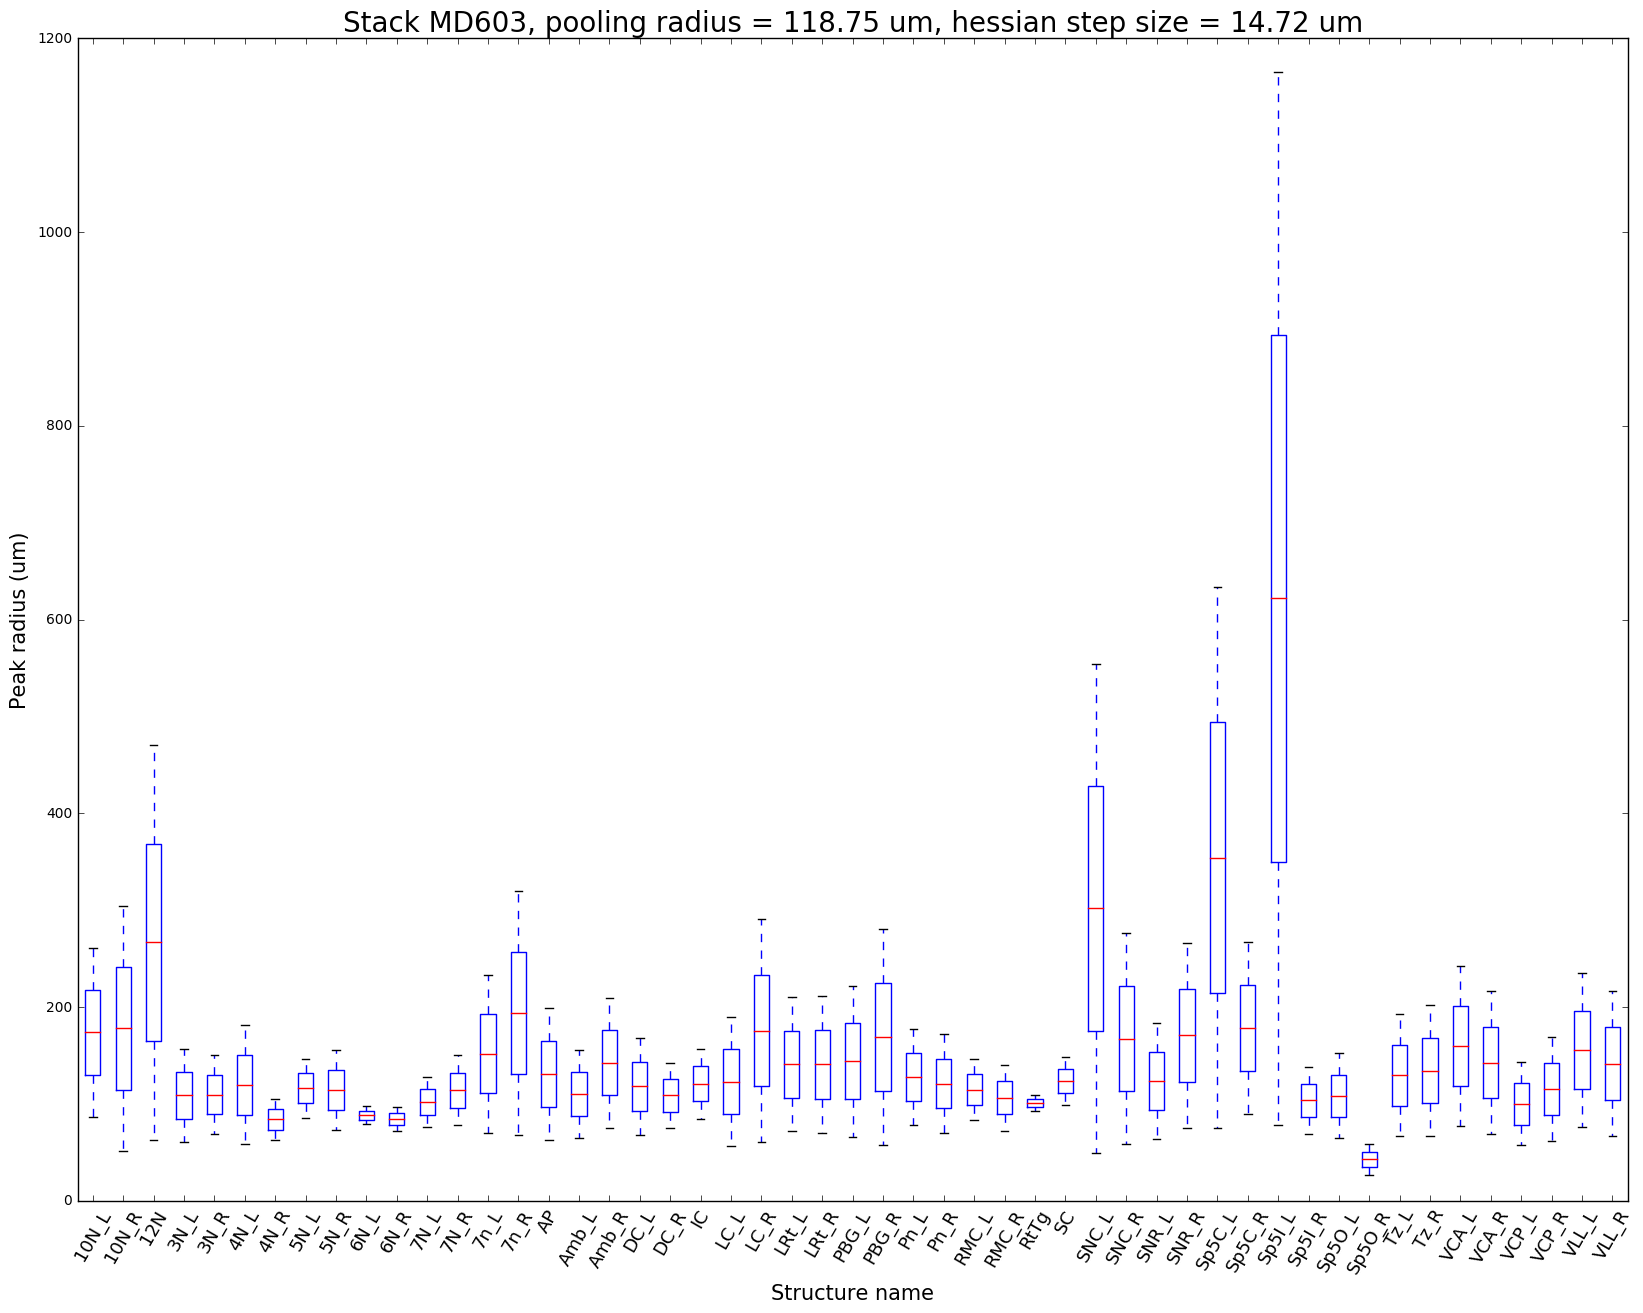

In [82]:
peak_radius_oneCombination = {struct: x[pool_radius][hessian_stepsize]
                              for struct, x in peak_radius_all_structures.iteritems()}
boxplot_labels = [struct for struct, x in sorted(peak_radius_oneCombination.items())]
D = [(prmax, prmin) for struct, (prmax, prmin) in sorted(peak_radius_oneCombination.items())]

plt.figure(figsize=(20, 15));
# plt.stem(range(1, len(boxplot_labels)+1), D);
plt.boxplot(D);
# plt.ylim([26, 42]);
plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name', fontsize=15);
plt.ylabel('Peak radius (um)', fontsize=15);
plt.title('Stack %s, pooling radius = %.2f um, hessian step size = %.2f um' % (stack_fixed, pool_radius, hessian_stepsize), fontsize=20);

# All stacks

In [105]:
pool_radius = pooling_radius_list[1]
hessian_stepsize = hessian_stepsize_list[0]

In [106]:
zsocres_all_structures_all_stacks_one_poolingRadius = defaultdict(dict)
for st, zs_all_structs in zscores_all_stacks_all_structures.iteritems():
    for struct, zs in zs_all_structs.iteritems():
        zsocres_all_structures_all_stacks_one_poolingRadius[struct][st] = zs[pool_radius][0]
        
zsocres_all_structures_all_stacks_one_poolingRadius.default_factory = None

In [107]:
structures_sided_sorted_by_size = ['4N_L', '4N_R', '6N_L', '6N_R', 'Amb_L', 'Amb_R', 'PBG_L', 'PBG_R', '10N_L', '10N_R', 'AP', '3N_L', '3N_R', 'LC_L', 'LC_R', 'SNC_L', 'SNC_R', 'Tz_L', 'Tz_R', '7n_L', '7n_R', 'RMC_L', 'RMC_R', '5N_L', '5N_R', 'VCP_L', 'VCP_R', '12N', 'LRt_L', 'LRt_R', '7N_L', '7N_R', 'VCA_L', 'VCA_R', 'VLL_L', 'VLL_R', 'DC_L', 'DC_R', 'Sp5O_L', 'Sp5O_R', 'Sp5I_L', 'Sp5I_R', 'Pn_L', 'Pn_R', 'RtTg', 'SNR_L', 'SNR_R', 'Sp5C_L', 'Sp5C_R', 'IC', 'SC']

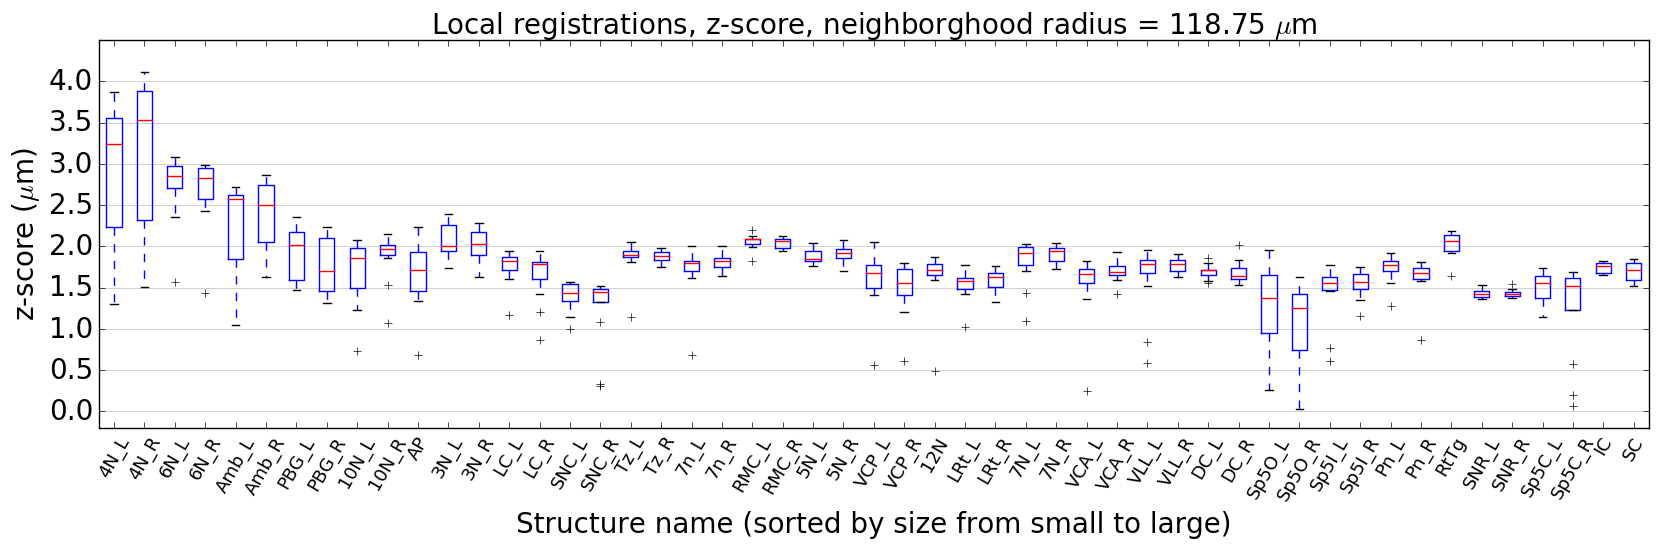

In [142]:
plt.figure(figsize=(20, 5));

D = [zsocres_all_structures_all_stacks_one_poolingRadius[struct].values()
for struct in structures_sided_sorted_by_size]

boxplot_labels = structures_sided_sorted_by_size

plt.boxplot(D);
plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.yticks(np.arange(0, 4.5, .5), map(str, np.arange(0, 4.5, .5)), fontsize=20);
plt.ylim([-.2,4.5]);
plt.xlabel('Structure name (sorted by size from small to large)', fontsize=20);
plt.ylabel('z-score ($\mu$m)', fontsize=20);
# plt.title('z-score', fontsize=20);
plt.title('Local registrations, z-score, neighborghood radius = %.2f $\mu$m' % (pool_radius), fontsize=20);

plt.gca().yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.5)
# Hide these grid behind plot objects
plt.gca().set_axisbelow(True)

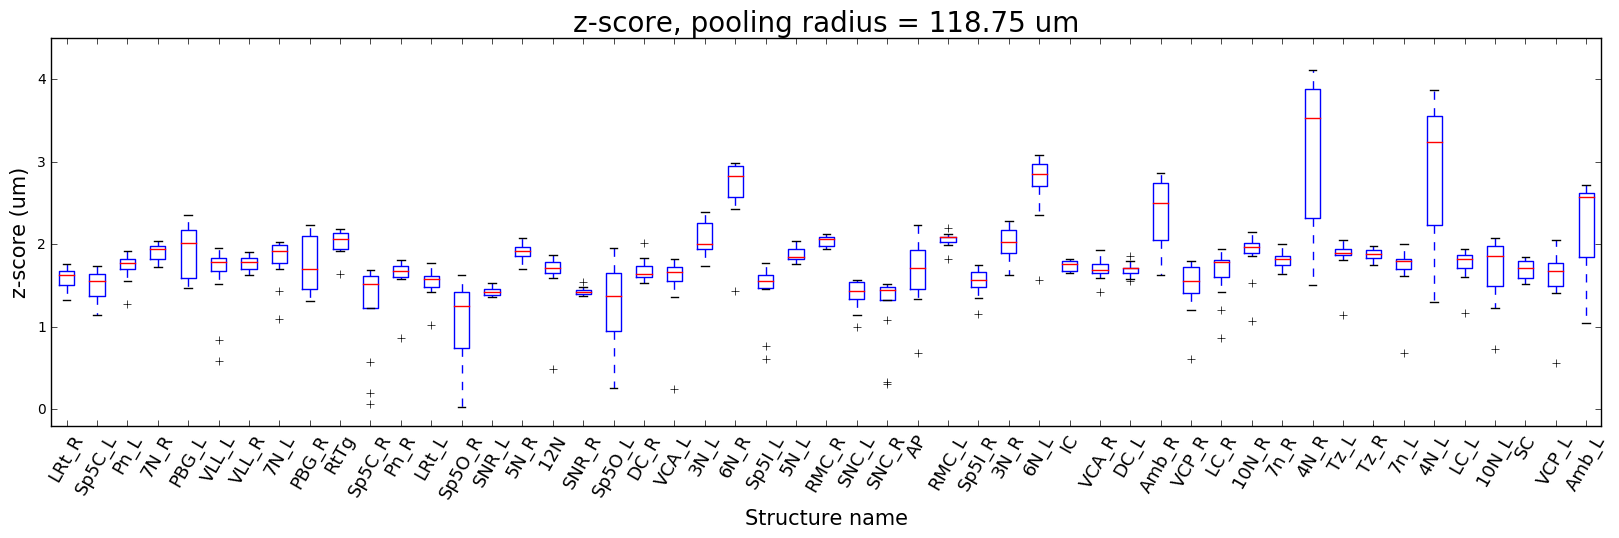

In [53]:
plt.figure(figsize=(20, 5));

D = [zs_all_stacks.values()
for struct, zs_all_stacks in zsocres_all_structures_all_stacks_one_poolingRadius.iteritems()]

boxplot_labels = zsocres_all_structures_all_stacks_one_poolingRadius.keys()

plt.boxplot(D);
plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.ylim([-.2,4.5]);
plt.xlabel('Structure name', fontsize=15);
plt.ylabel('z-score (um)', fontsize=15);
plt.title('z-score, pooling radius = %.2f um' % (pool_radius), fontsize=20);

In [54]:
np.mean(D)

1.7875308851525931

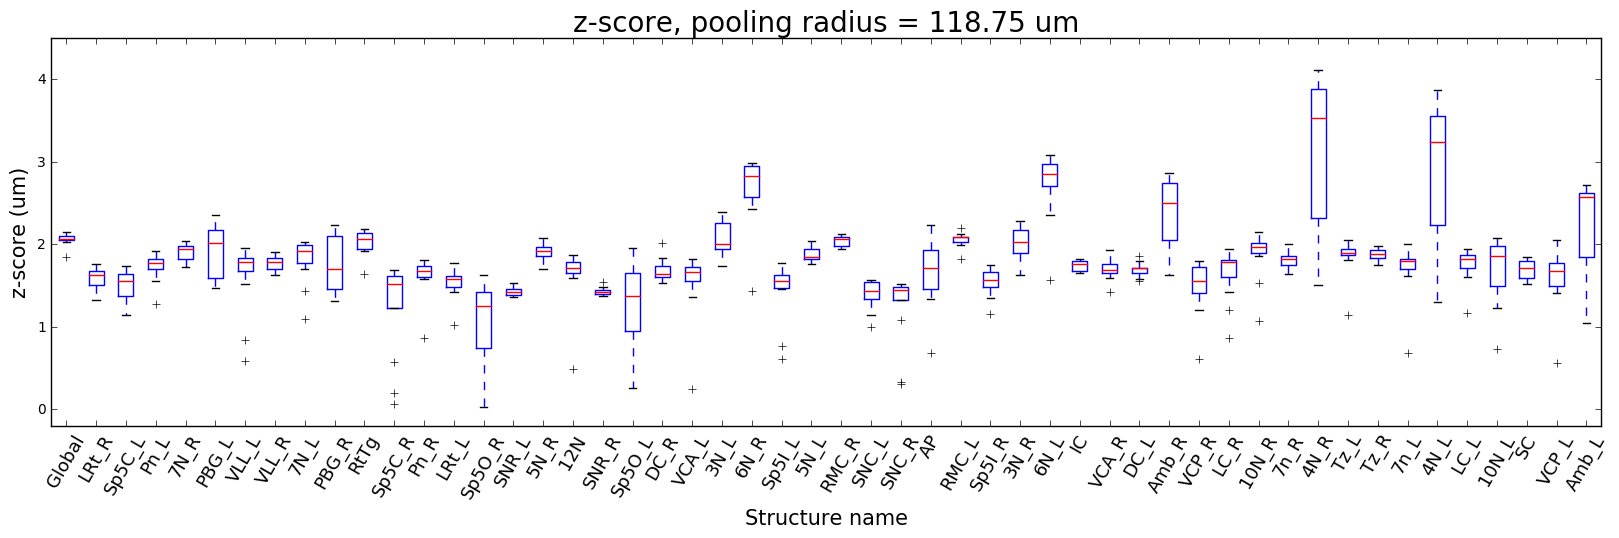

In [46]:
# Add global as extra column.

plt.figure(figsize=(20, 5));

D = [zs_all_stacks.values()
for struct, zs_all_stacks in zsocres_all_structures_all_stacks_one_poolingRadius.iteritems()]

D1 = np.vstack([zscore_toplot_all_stacks.values(), D]).T

boxplot_labels = ['Global'] + zsocres_all_structures_all_stacks_one_poolingRadius.keys()

plt.boxplot(D1);
plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.ylim([-.2,4.5]);
plt.xlabel('Structure name', fontsize=15);
plt.ylabel('z-score (um)', fontsize=15);
plt.title('z-score, neighborhood radius = %.2f um' % (pool_radius), fontsize=20);

# Plot peak radius

In [133]:
pool_radius = pooling_radius_list[1]
hessian_stepsize = hessian_stepsize_list[0]
print pool_radius
print hessian_stepsize

118.75
14.72


In [ ]:
peak_radius_max_oneCombination = defaultdict(dict)
peak_radius_min_oneCombination = defaultdict(dict)
for stack, x_per_stack in peak_radius_all_stacks_all_structures.iteritems():
    for struct, x in x_per_stack.iteritems():
        prmax, prmin = x[pool_radius][hessian_stepsize]
        peak_radius_min_oneCombination[struct][stack] = prmin
        peak_radius_max_oneCombination[struct][stack] = prmax

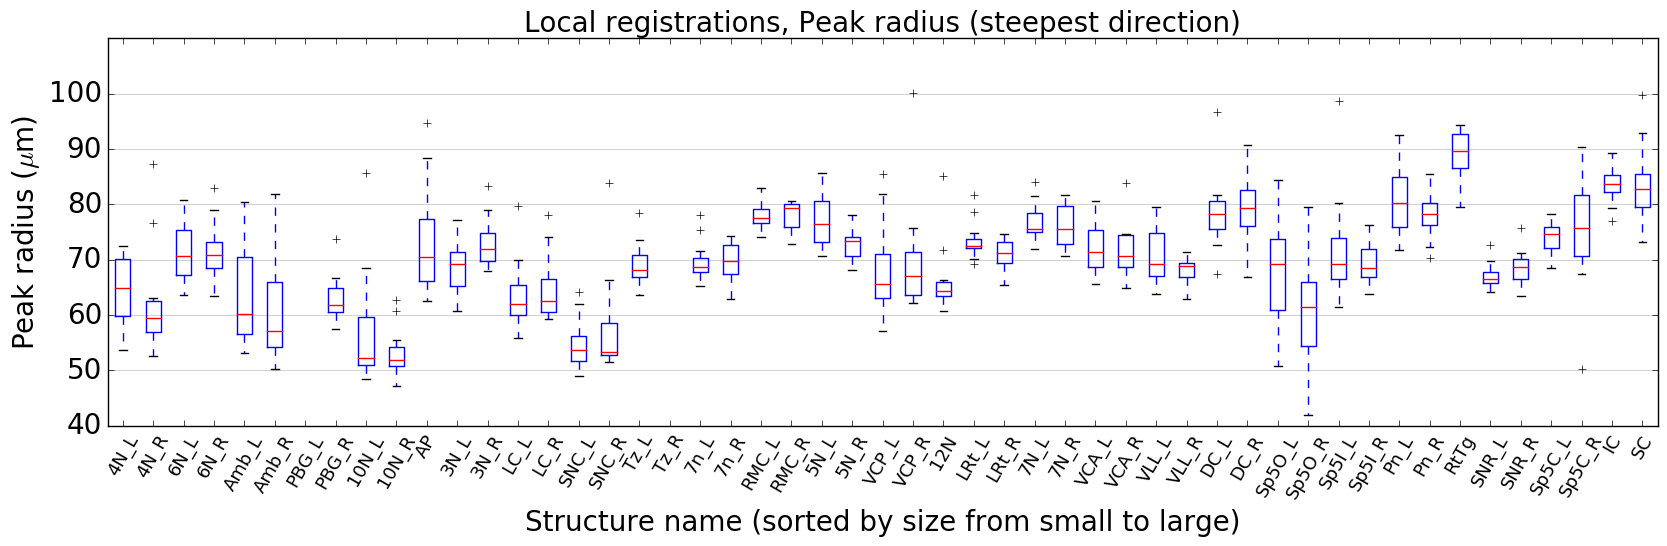

In [151]:
plt.figure(figsize=(20, 5));

boxplot_labels = structures_sided_sorted_by_size
D = [peak_radius_min_oneCombination[struct].values() for struct in structures_sided_sorted_by_size]
plt.boxplot(D);
plt.ylim([40, 110]);
plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name (sorted by size from small to large)', fontsize=20);
plt.yticks(np.arange(40, 110, 10), map(str, np.arange(40, 110, 10)), fontsize=20);
plt.ylabel('Peak radius ($\mu$m)', fontsize=20);
plt.title('Local registrations, Peak radius (steepest direction)', fontsize=20);

plt.gca().yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.5)
# Hide these grid behind plot objects
plt.gca().set_axisbelow(True)

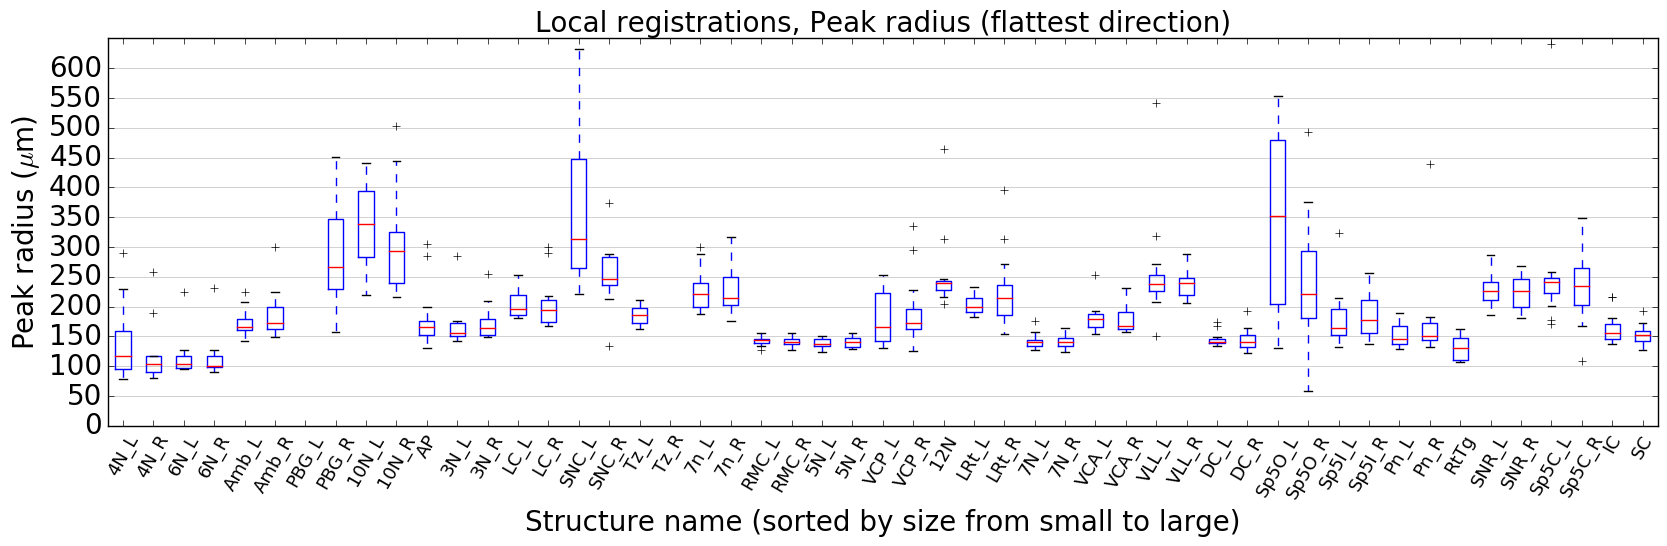

In [159]:
plt.figure(figsize=(20, 5));

boxplot_labels = structures_sided_sorted_by_size
D = [peak_radius_max_oneCombination[struct].values() for struct in structures_sided_sorted_by_size]
plt.boxplot(D);
plt.ylim([0, 650]);
plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name (sorted by size from small to large)', fontsize=20);
plt.yticks(np.arange(0, 650, 50), map(str, np.arange(0, 650, 50)), fontsize=20);
plt.ylabel('Peak radius ($\mu$m)', fontsize=20);
plt.title('Local registrations, Peak radius (flattest direction)', fontsize=20);

plt.gca().yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.5)
# Hide these grid behind plot objects
plt.gca().set_axisbelow(True)

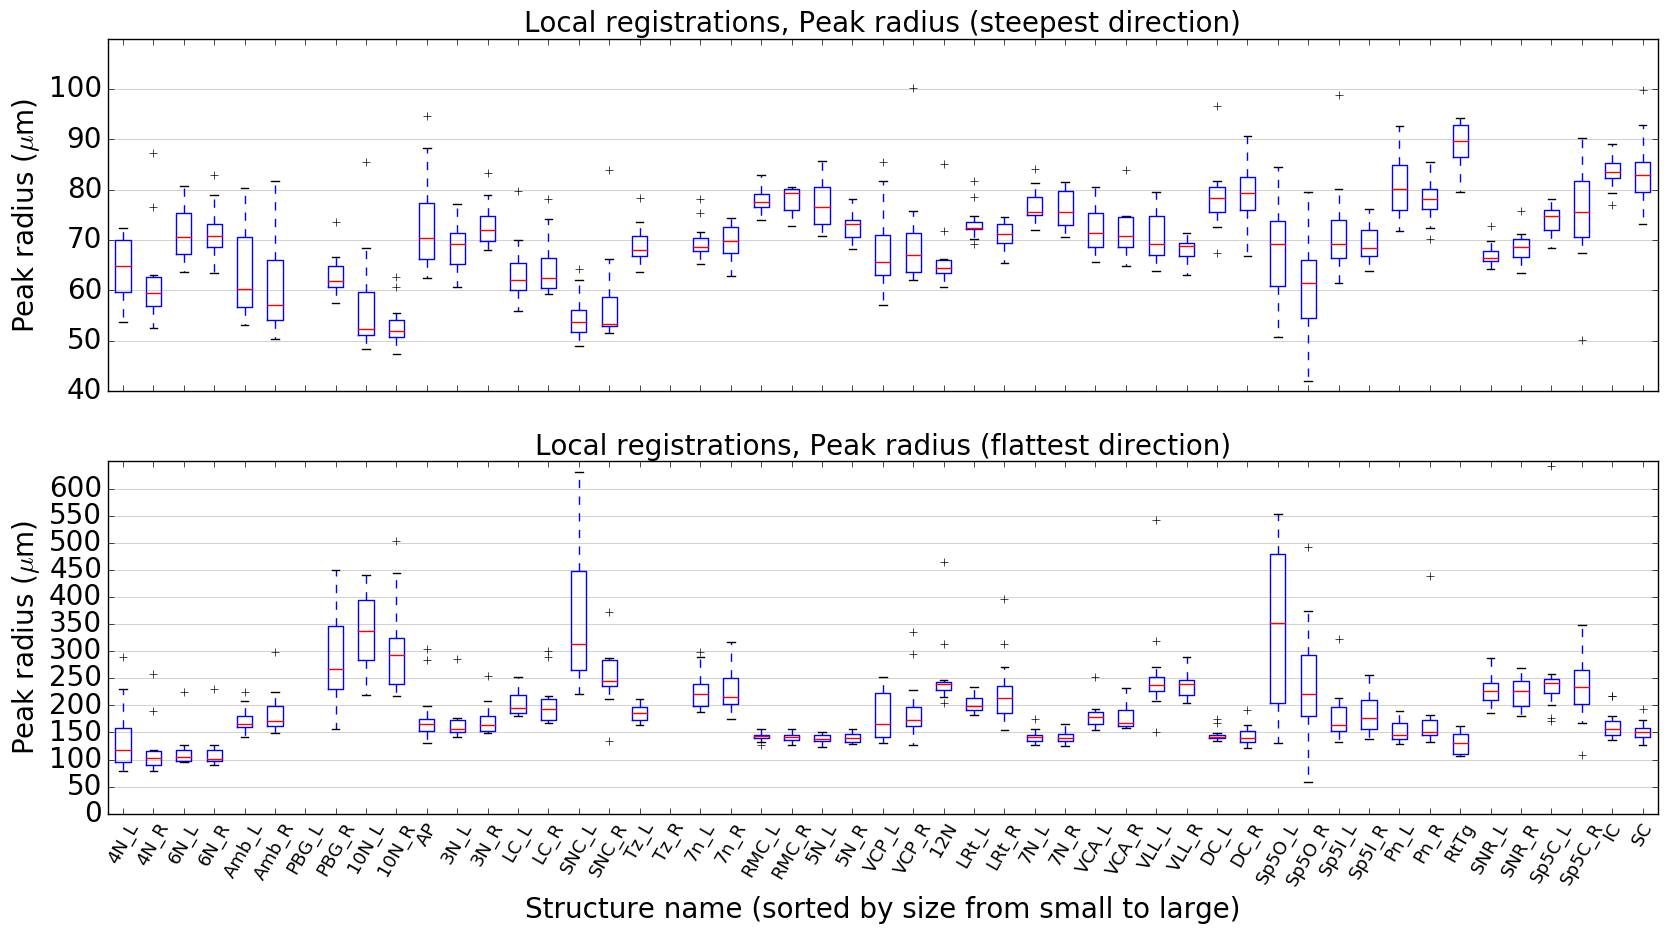

In [174]:
# Both falttest/steepest directions in a subplot.

fig, axes = plt.subplots(2, 1, figsize=(20,10), sharex=True);

boxplot_labels = structures_sided_sorted_by_size
D = [peak_radius_min_oneCombination[struct].values() for struct in structures_sided_sorted_by_size]
axes[0].boxplot(D);
axes[0].set_ylim([40, 110]);

axes[0].set_yticks(np.arange(40, 110, 10));
axes[0].set_yticklabels(map(str, np.arange(40, 110, 10)), fontsize=20);
axes[0].set_ylabel('Peak radius ($\mu$m)', fontsize=20);
axes[0].set_title('Local registrations, Peak radius (steepest direction)', fontsize=20);

axes[0].yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.5)
# Hide these grid behind plot objects
axes[0].set_axisbelow(True)

boxplot_labels = structures_sided_sorted_by_size
D = [peak_radius_max_oneCombination[struct].values() for struct in structures_sided_sorted_by_size]
axes[1].boxplot(D);
axes[1].set_ylim([0, 650]);
axes[1].set_yticks(np.arange(0, 650, 50));
axes[1].set_yticklabels(map(str, np.arange(0, 650, 50)), fontsize=20);
axes[1].set_ylabel('Peak radius ($\mu$m)', fontsize=20);
axes[1].set_title('Local registrations, Peak radius (flattest direction)', fontsize=20);

axes[1].yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.5)
# Hide these grid behind plot objects
axes[1].set_axisbelow(True)

plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name (sorted by size from small to large)', fontsize=20);

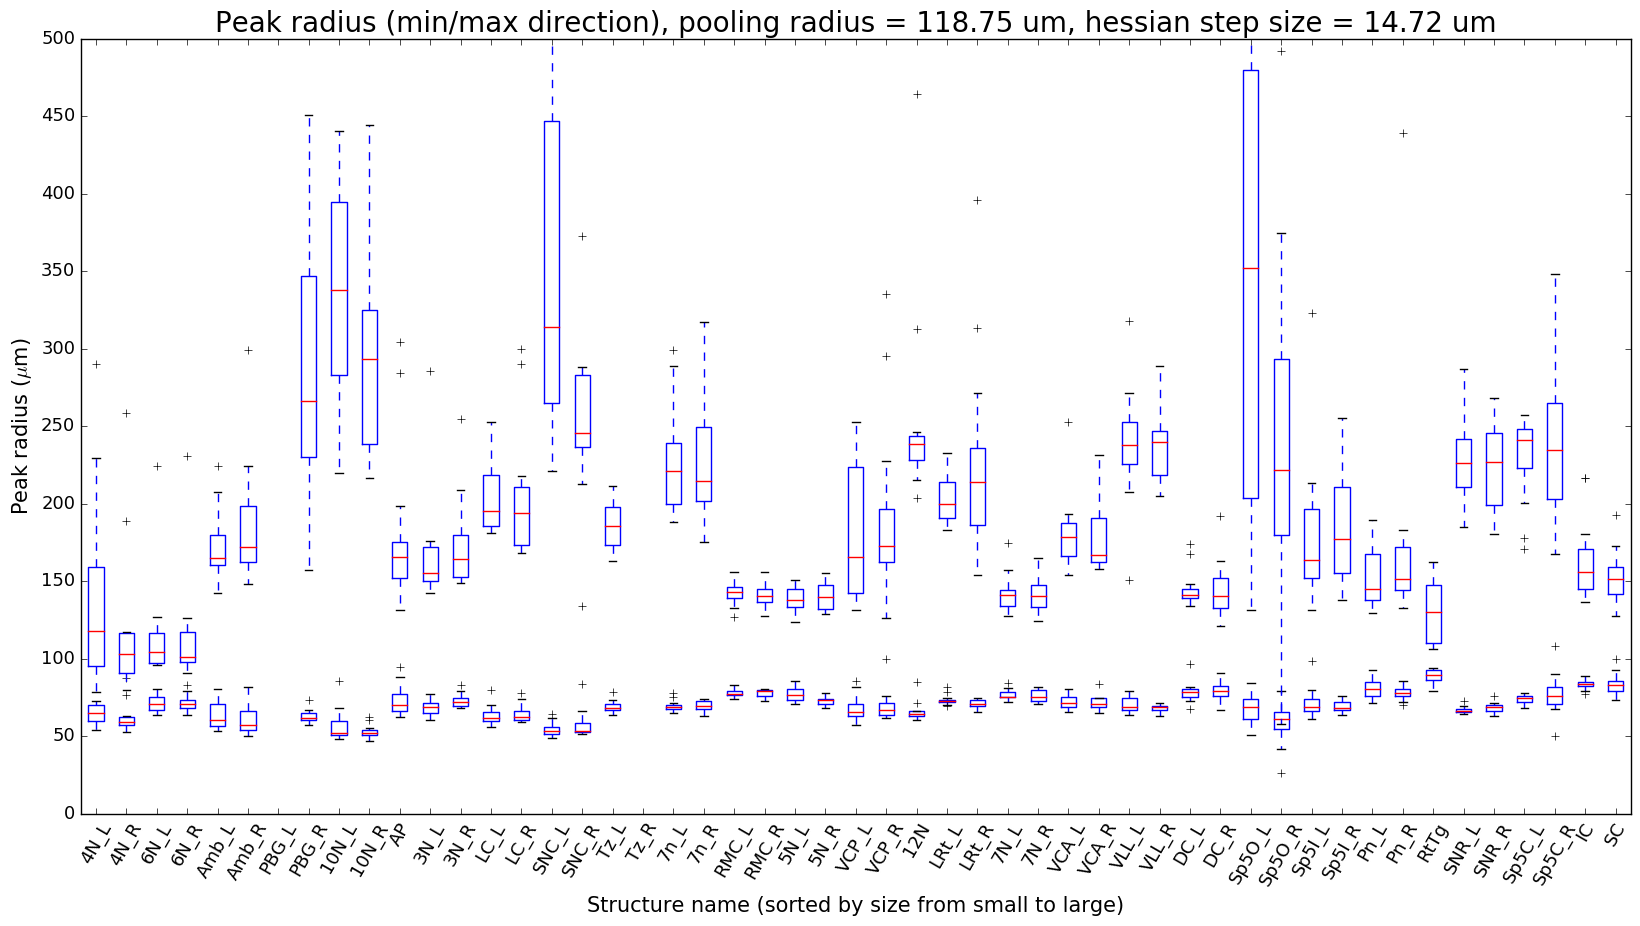

In [135]:
plt.figure(figsize=(20, 10));

boxplot_labels = structures_sided_sorted_by_size
D = [peak_radius_min_oneCombination[struct].values() for struct in structures_sided_sorted_by_size]

# plt.figure(figsize=(20, 15));
# # plt.stem(range(1, len(boxplot_labels)+1), D);
plt.boxplot(D);
# # plt.ylim([26, 42]);
# plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
# plt.xlabel('Structure name', fontsize=15);
# plt.ylabel('Peak radius (um)', fontsize=15);
# plt.title('Peak radius min, pooling radius = %.2f um, hessian step size = %.2f um' % (pool_radius, hessian_stepsize), fontsize=20);

###########################        

boxplot_labels = structures_sided_sorted_by_size
D = [peak_radius_max_oneCombination[struct].values() for struct in structures_sided_sorted_by_size]

# plt.figure(figsize=(20, 15));
# plt.stem(range(1, len(boxplot_labels)+1), D);
plt.boxplot(D);
plt.ylim([0, 500]);
plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name (sorted by size from small to large)', fontsize=15);
plt.yticks(np.arange(0, 550, 50), map(str, np.arange(0, 550, 50)), fontsize=13);
plt.ylabel('Peak radius ($\mu$m)', fontsize=15);
plt.title('Local registrations, Peak radius (min/max direction), pooling radius = %.2f um, hessian step size = %.2f um' % (pool_radius, hessian_stepsize), fontsize=20);

In [29]:
def plot_peak_radius(peak_radius):
    # Plot

    for poolradius_um, v in peak_radius.iteritems():
        xs, ys_max_min = zip(*sorted(v.items()))
        ys_max, ys_min = zip(*ys_max_min)
        c = np.array(random_colors(1)[0])/255.
        plt.plot(xs, ys_max, linestyle='-', color=c, label='pool=%dum, max' % poolradius_um);
        plt.plot(xs, ys_min, linestyle='--', color=c, label='pool=%dum, min' % poolradius_um);
    plt.legend(loc='lower right');
    # plt.title('Peak radius');
    plt.xlabel('Hessian step size (um)');
    plt.ylabel('Peak radius (um)');
    plt.show();

In [ ]:
# Old

In [ ]:
# peak radius computed using largest eigenvalue

peak_radius_allStructures = {}
zscores_allStructures = {}

for name_s in structures_sided:
        
#     hessian_fp = DataManager.get_hessian_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
#                                         moving_volume_type='score', fixed_volume_type='score', 
#                                         label=name_s,
#                                         train_sample_scheme=train_sample_scheme, 
#                                         global_transform_scheme=global_transform_scheme, 
#                                         local_transform_scheme=local_transform_scheme)  
#     hessians = load_pickle(hessian_fp)
    
#     zscore_fp = DataManager.get_zscore_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
#                                         moving_volume_type='score', fixed_volume_type='score', 
#                                         label=name_s,
#                                         train_sample_scheme=train_sample_scheme, 
#                                         global_transform_scheme=global_transform_scheme, 
#                                         local_transform_scheme=local_transform_scheme)
#     zscores = load_pickle(zscore_fp)
    
    zscores_allStructures[name_s] = zscores
    
    ###################################################
        
    peak_radius = {}
        
    for pooling_radius, (zscore, fmax, mu, std) in zscores.iteritems():
        
        peak_radius[pooling_radius] = {}
        
        for step_size, (H, fmax) in hessians.iteritems():
            if pooling_radius > step_size * 2:  # compute only if pooling radius is at least twice the step size
                U, S, UT = np.linalg.svd(H)
                peak_radius[pooling_radius][step_size] = np.sqrt(2*(fmax-mu)/S[0])

    peak_radius_allStructures[name_s] = peak_radius

In [ ]:
# Compute peak radius using the largest eigenvalues of Hessians

for pooling_radius, (zscore, fmax, mu, std) in zscores.iteritems():
    peak_radius[pooling_radius] = {}
    for step_size, (H, fmax) in Hs.iteritems():
        if pooling_radius > step_size * 2:  # compute only if pooling radius is at least twice the step size
            U, S, UT = np.linalg.svd(H)
            peak_radius[pooling_radius][step_size] = np.sqrt(2*(fmax-mu)/S[0])

peak_radius_allStructures[name_s] = peak_radius

# Compute peak radius using the smallest eigenvalues of Hessians

for pooling_radius, (zscore, fmax, mu, std) in zscores.iteritems():
    peak_radius[pooling_radius] = {}
    for step_size, (H, fmax) in Hs.iteritems():
        if pooling_radius > step_size * 2:  # compute only if pooling radius is at least twice the step size
            U, S, UT = np.linalg.svd(H)
            peak_radius[pooling_radius][step_size] = np.sqrt(2*(fmax-mu)/S[-1])

peak_radius_allStructures[name_s] = peak_radius

# Local

In [ ]:
#END

In [ ]:
fp = DataManager.get_hessian_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                        moving_volume_type='score', fixed_volume_type='score', 
                                        label=name_s,
                                        train_sample_scheme=train_sample_scheme, 
                                        global_transform_scheme=global_transform_scheme, 
                                        local_transform_scheme=local_transform_scheme)
    
hessians = load_pickle(fp)

In [15]:
zscores_allStructures = {}

for name_s in structures_sided:
    
    fp = DataManager.get_zscore_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                    moving_volume_type='score', fixed_volume_type='score', 
                                    label=name_s,
                                    train_sample_scheme=train_sample_scheme, 
                                    global_transform_scheme=global_transform_scheme, 
                                    local_transform_scheme=local_transform_scheme)

    zscores = load_pickle(fp)
    
    zscores_allStructures[name_s] = zscores

In [16]:
pooling_radius_list = sorted(zscores_allStructures['7N_L'].keys())

In [17]:
D = np.array([[z[0] for r, z in d.items()] for n, d in sorted(zscores_allStructures.items())])

In [18]:
boxplot_labels = sorted(zscores_allStructures.keys())

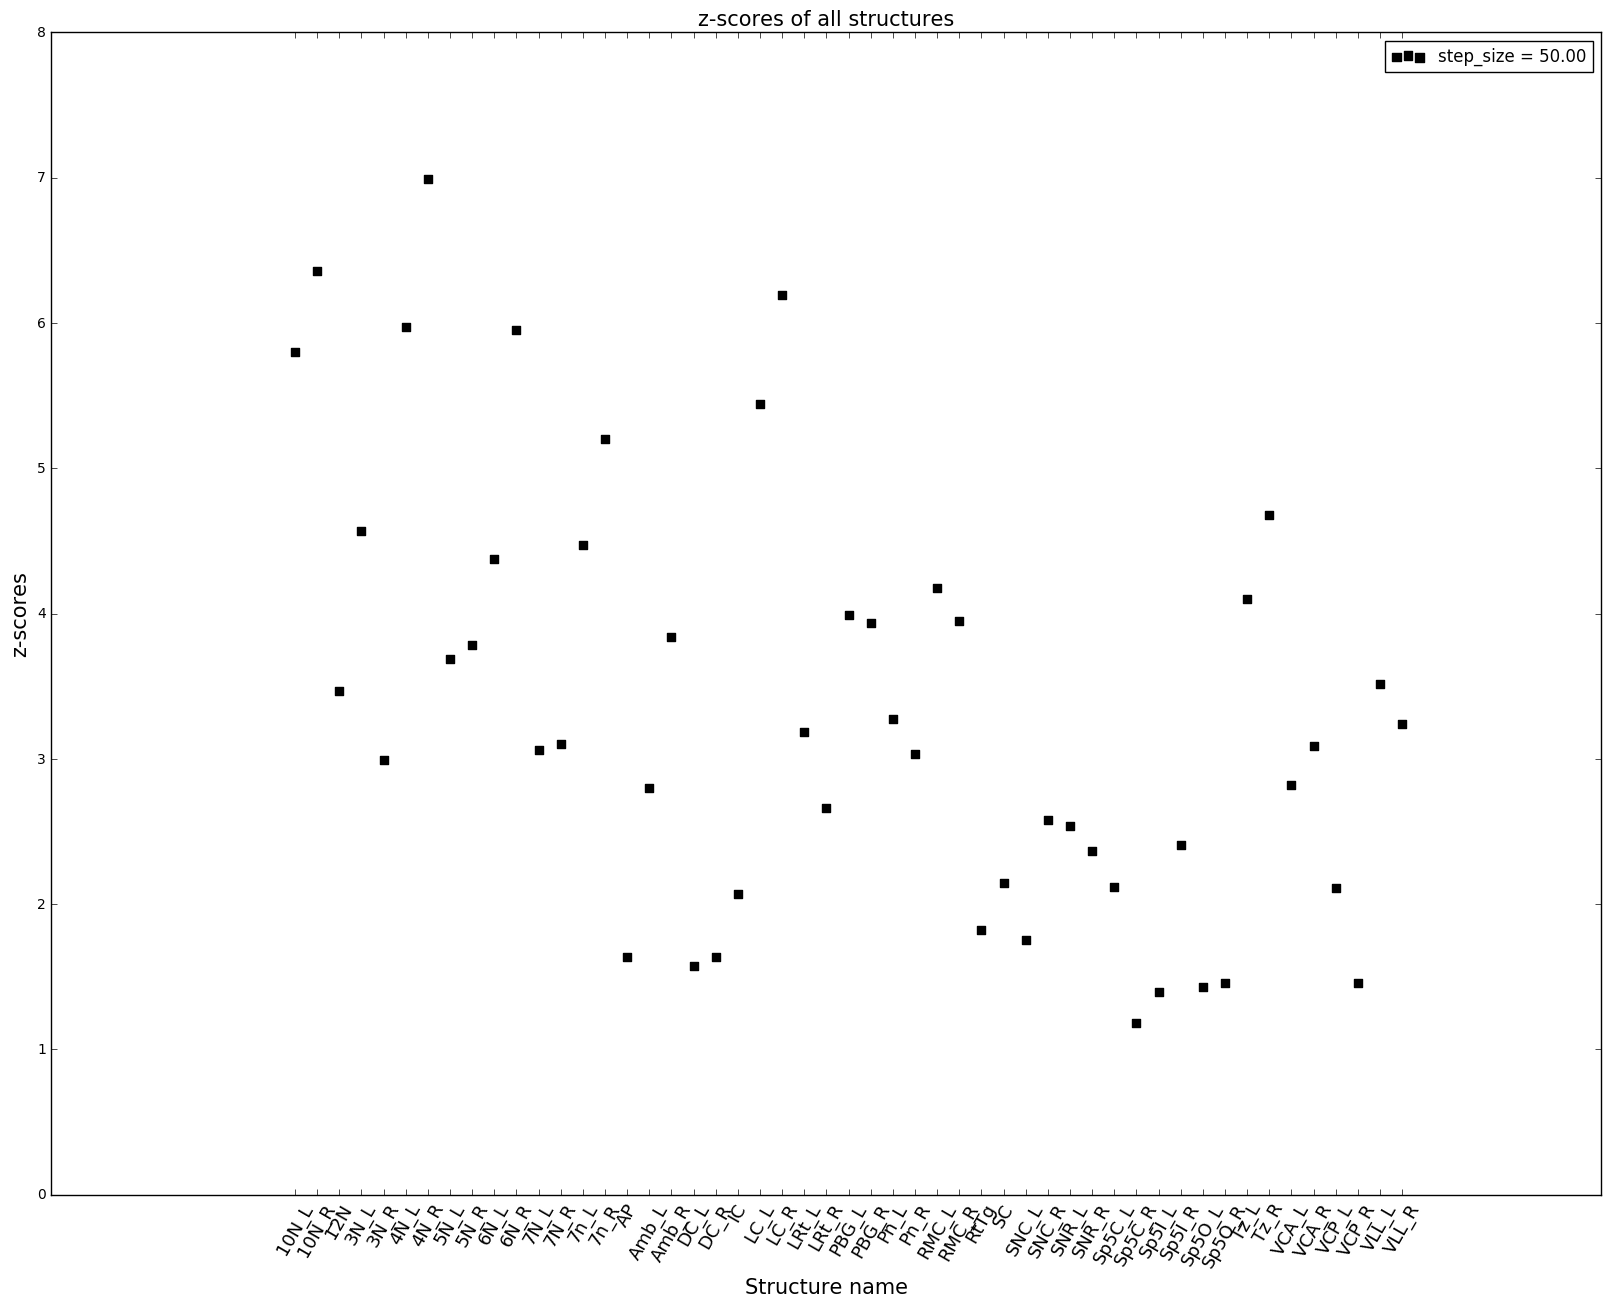

In [41]:
fig = plt.figure(figsize=(20, 15));
# fig, axes = plt.subplots(4, 1, figsize=(20, 30), sharex=False, sharey=True);

# plt.scatter(range(1, len(boxplot_labels)+1), D[:,0], marker='o', s=40, c='b', label='step_size = %.2f' % pooling_radius_list[0]);
# plt.scatter(range(1, len(boxplot_labels)+1), D[:,1], marker='^', s=40, c='g', label='step_size = %.2f' % pooling_radius_list[1]);
# plt.scatter(range(1, len(boxplot_labels)+1), D[:,2], marker='*', s=40, c='r', label='step_size = %.2f' % pooling_radius_list[2]);
plt.scatter(range(1, len(boxplot_labels)+1), D[:,3], marker='s', s=40, c='k', label='step_size = %.2f' % pooling_radius_list[3]);

plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name', fontsize=15);
# plt.yticks(np.arange(0.2, 5, .1), fontsize=15);
plt.ylabel('z-scores', fontsize=15);
plt.title('z-scores of all structures', fontsize=15);
plt.legend();

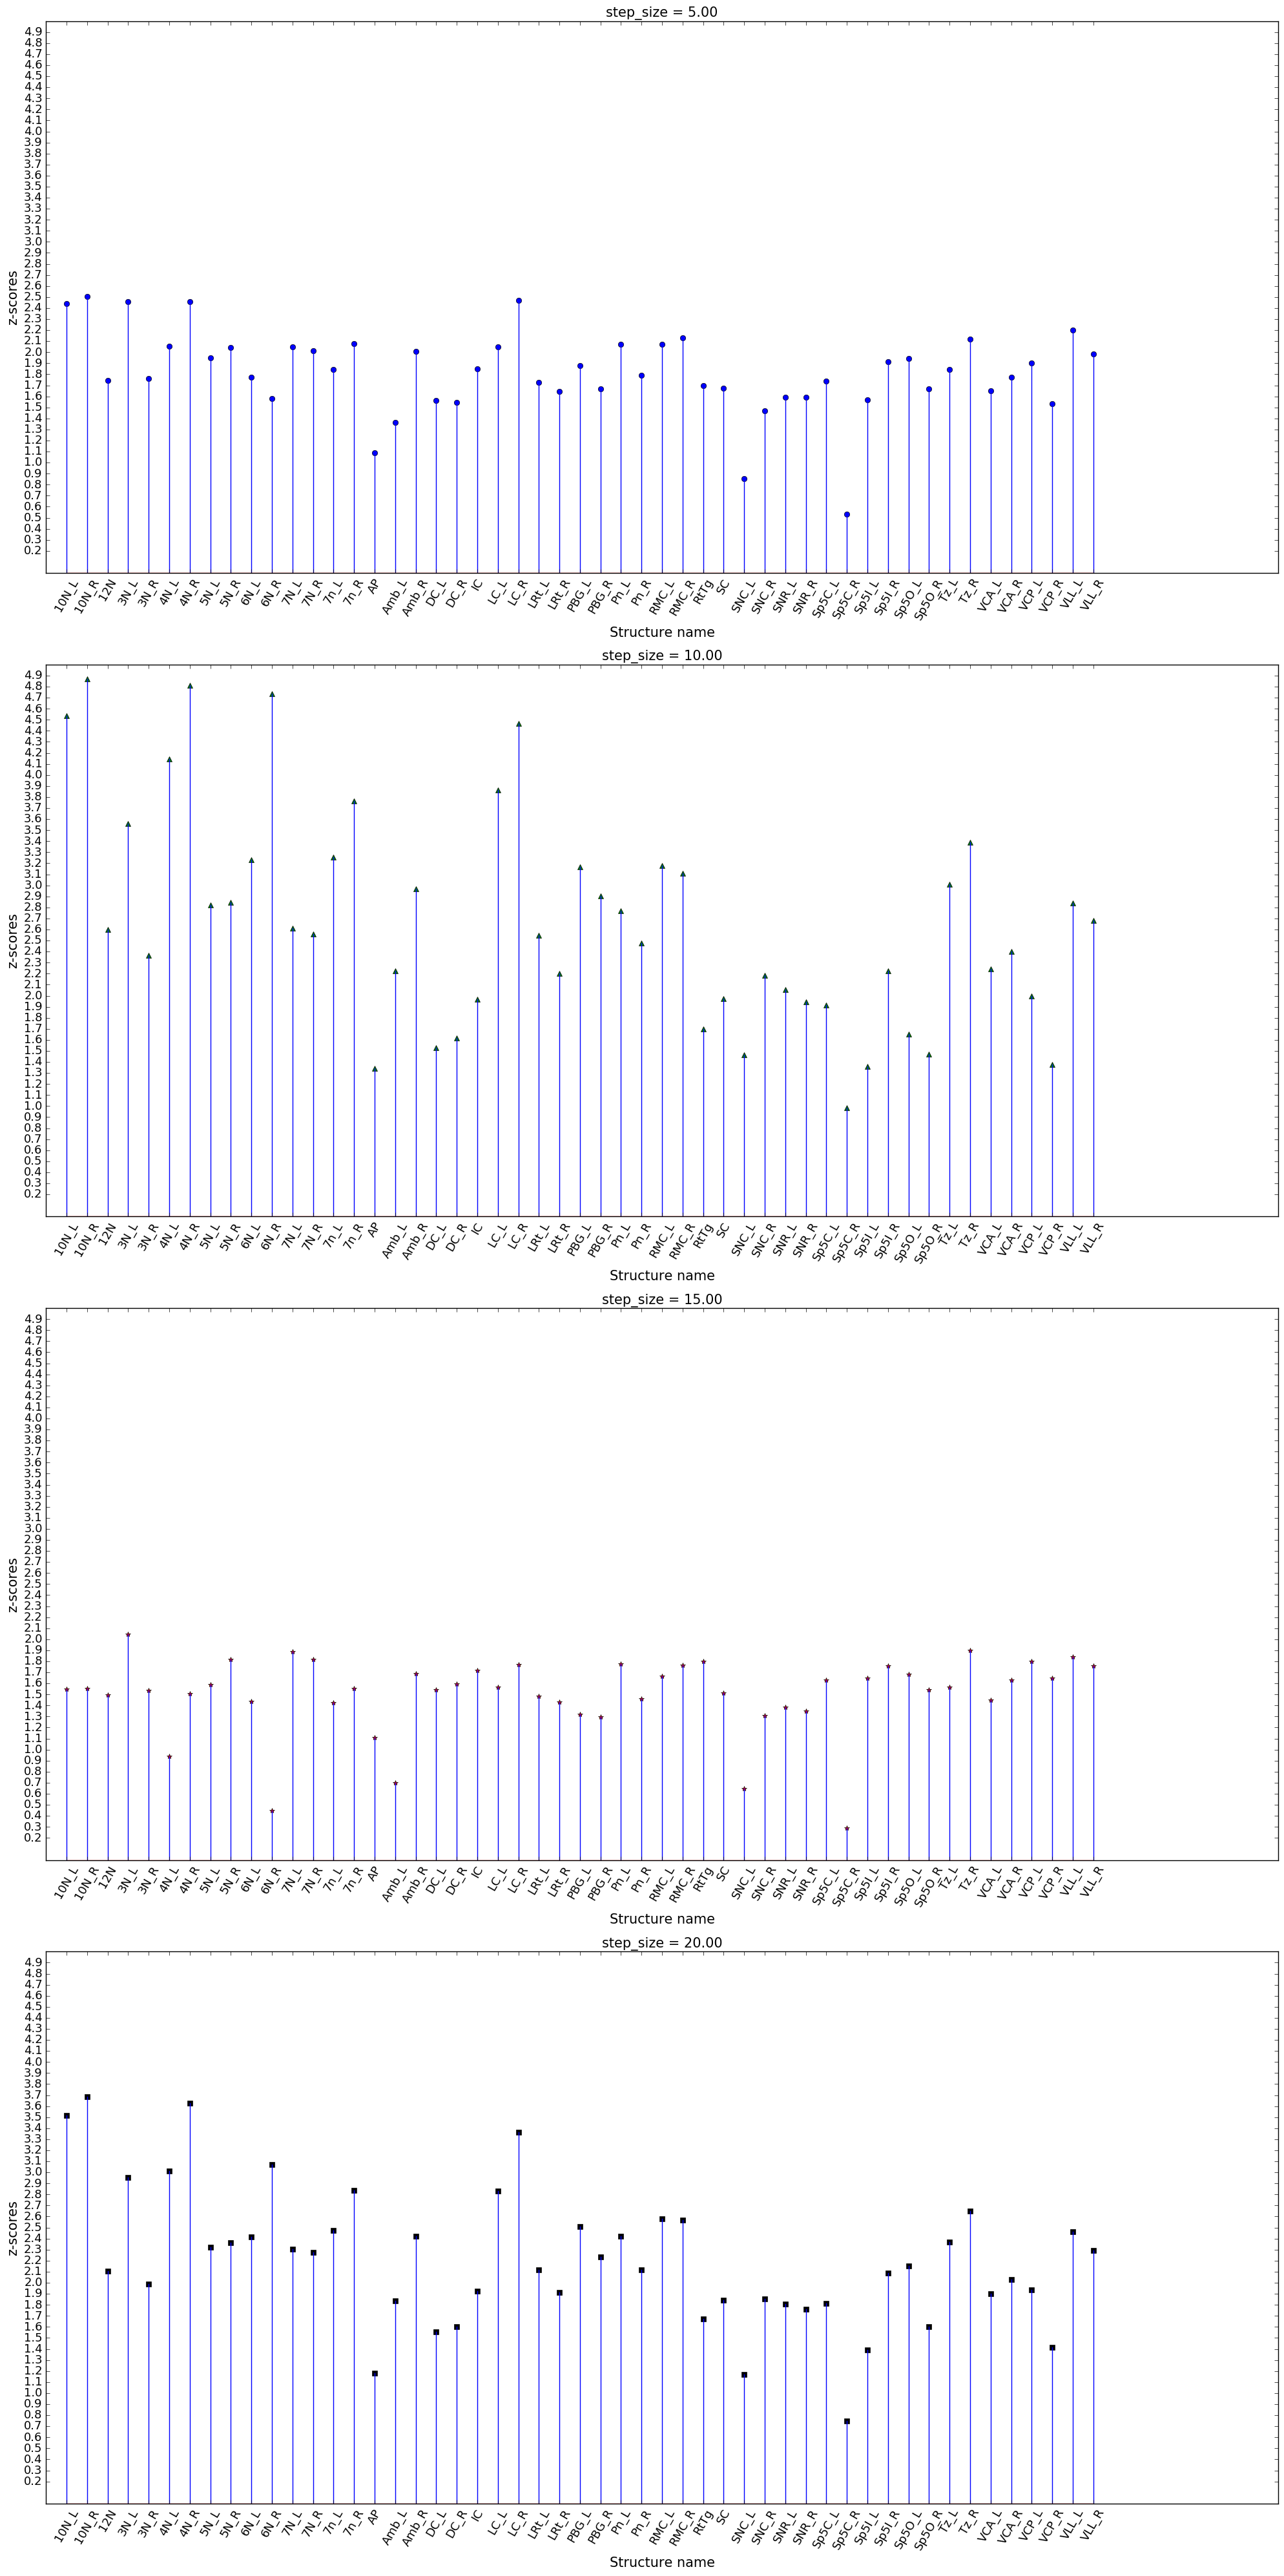

In [175]:
# fig = plt.figure(figsize=(20, 15));
fig, axes = plt.subplots(4, 1, figsize=(20, 40), sharex=False, sharey=True);

axes[0].stem(range(1, len(boxplot_labels)+1), D[:,0], markerfmt='bo', s=40);
axes[1].stem(range(1, len(boxplot_labels)+1), D[:,1], markerfmt='g^', s=40);
axes[2].stem(range(1, len(boxplot_labels)+1), D[:,2], markerfmt='r*', s=40);
axes[3].stem(range(1, len(boxplot_labels)+1), D[:,3], markerfmt='ks', s=40);

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, len(boxplot_labels)+1))
    ax.set_xticklabels(boxplot_labels, rotation='60', fontsize=13);
    ax.set_xlabel('Structure name', fontsize=15);
    ax.set_yticks(np.arange(0.2, 5, .1));
    ax.set_yticklabels(np.arange(0.2, 5, .1), fontsize=13);
    ax.set_ylabel('z-scores', fontsize=15);
    ax.set_title('step_size = %.2f' % pooling_radius_list[i], fontsize=15);

plt.tight_layout()

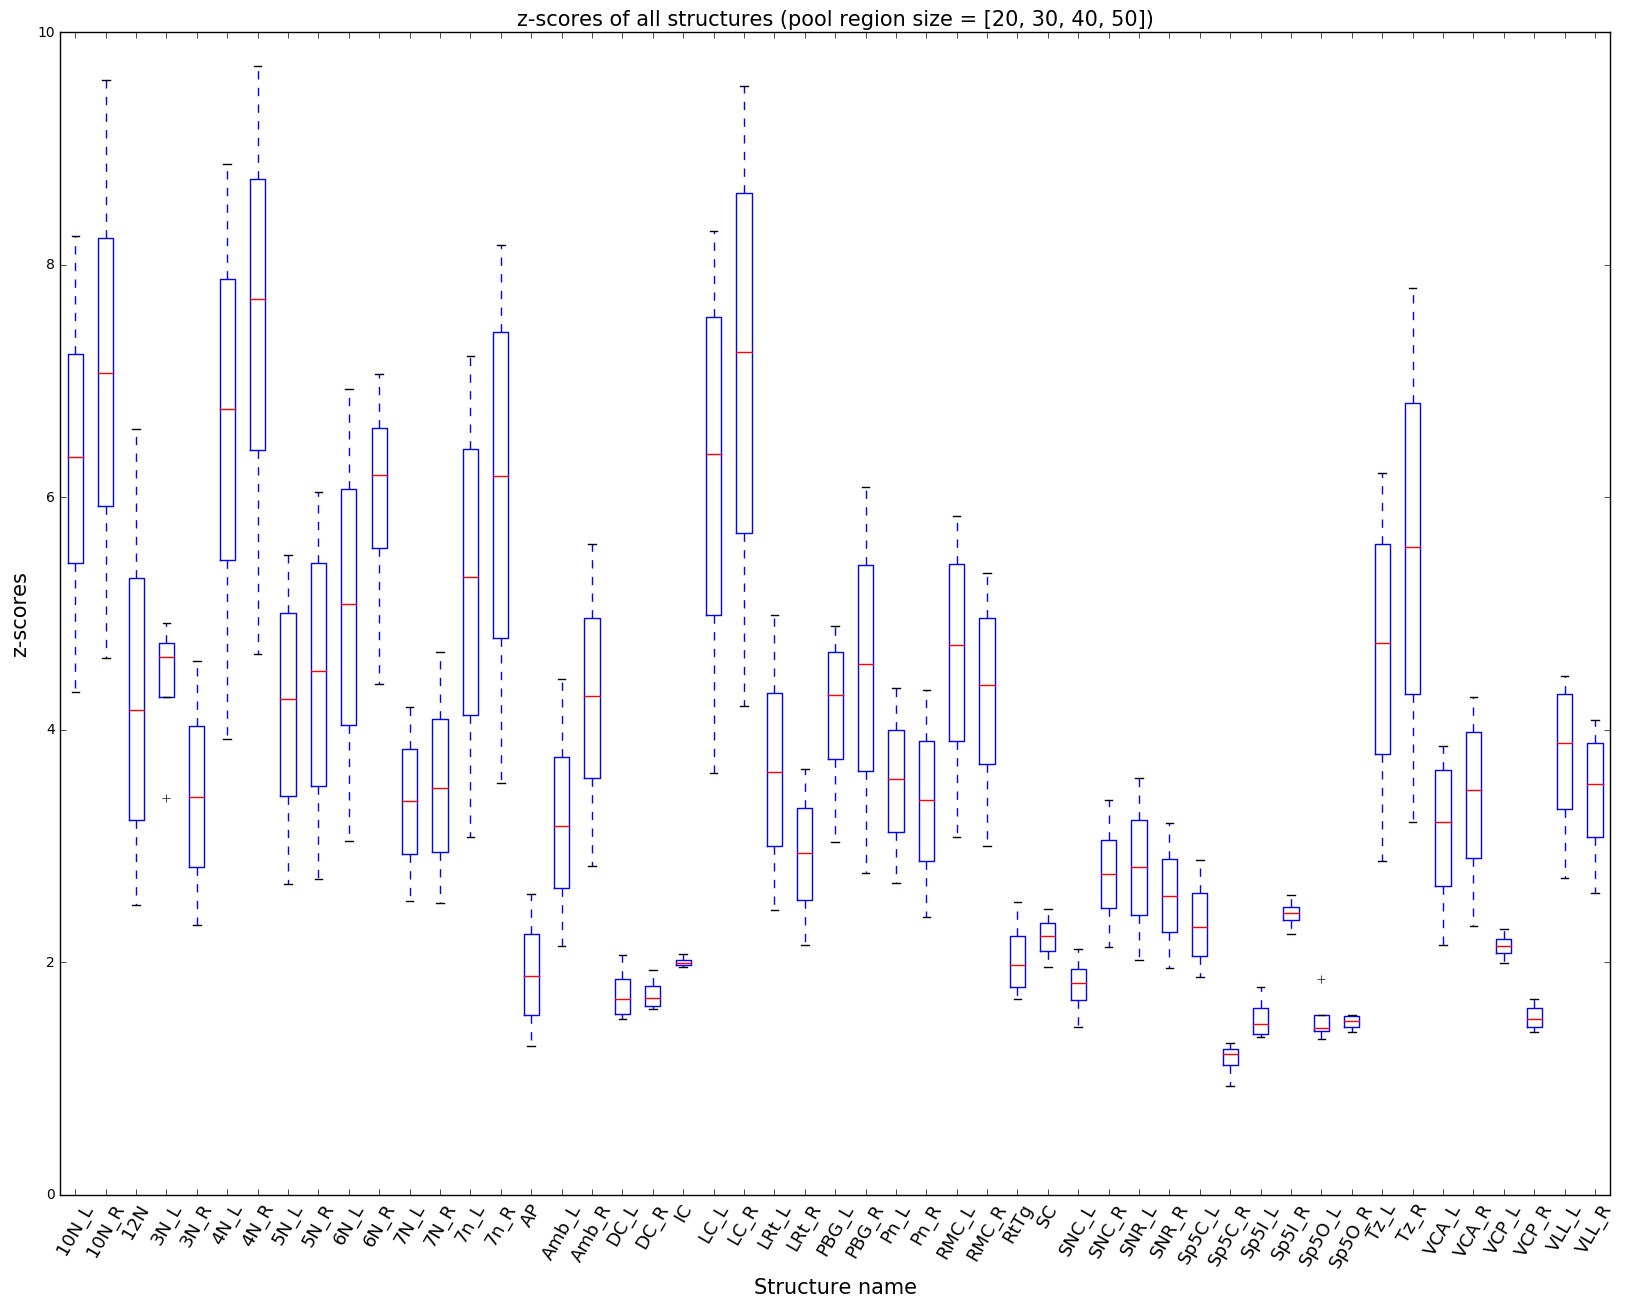

In [21]:
plt.figure(figsize=(20, 15));
plt.boxplot(D.T);
plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name', fontsize=15);
# plt.yticks(np.arange(0.2, 5, .1), fontsize=15);
plt.ylabel('z-scores', fontsize=15);
plt.title('z-scores of all structures (pool region size = %s)' % pooling_radius_list, fontsize=15);

In [89]:
volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}

# for lm, s in volume_moving_structure_sizes.iteritems():
#     print label_to_name_moving[lm], s, 'voxels'

In [127]:
dets_allStructures = {}

for name_s in structures_sided:

        
    fp = DataManager.get_hessian_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                        moving_volume_type='score', fixed_volume_type='score', 
                                        label=name_s,
                                        train_sample_scheme=train_sample_scheme, 
                                        global_transform_scheme=global_transform_scheme, 
                                        local_transform_scheme=local_transform_scheme)
    
    hessians = load_pickle(fp)
    
    dets = {step_size: np.abs(np.linalg.det(H / volume_moving_structure_sizes[name_to_label_moving[name_s]]))
            for step_size, H in hessians.iteritems()}
    
    dets_allStructures[name_s] = dets

In [134]:
H = [[z for r, z in d.items()][5:7] for n, d in sorted(dets_allStructures.items())]

In [130]:
boxplot_labels = sorted(dets_allStructures.keys())

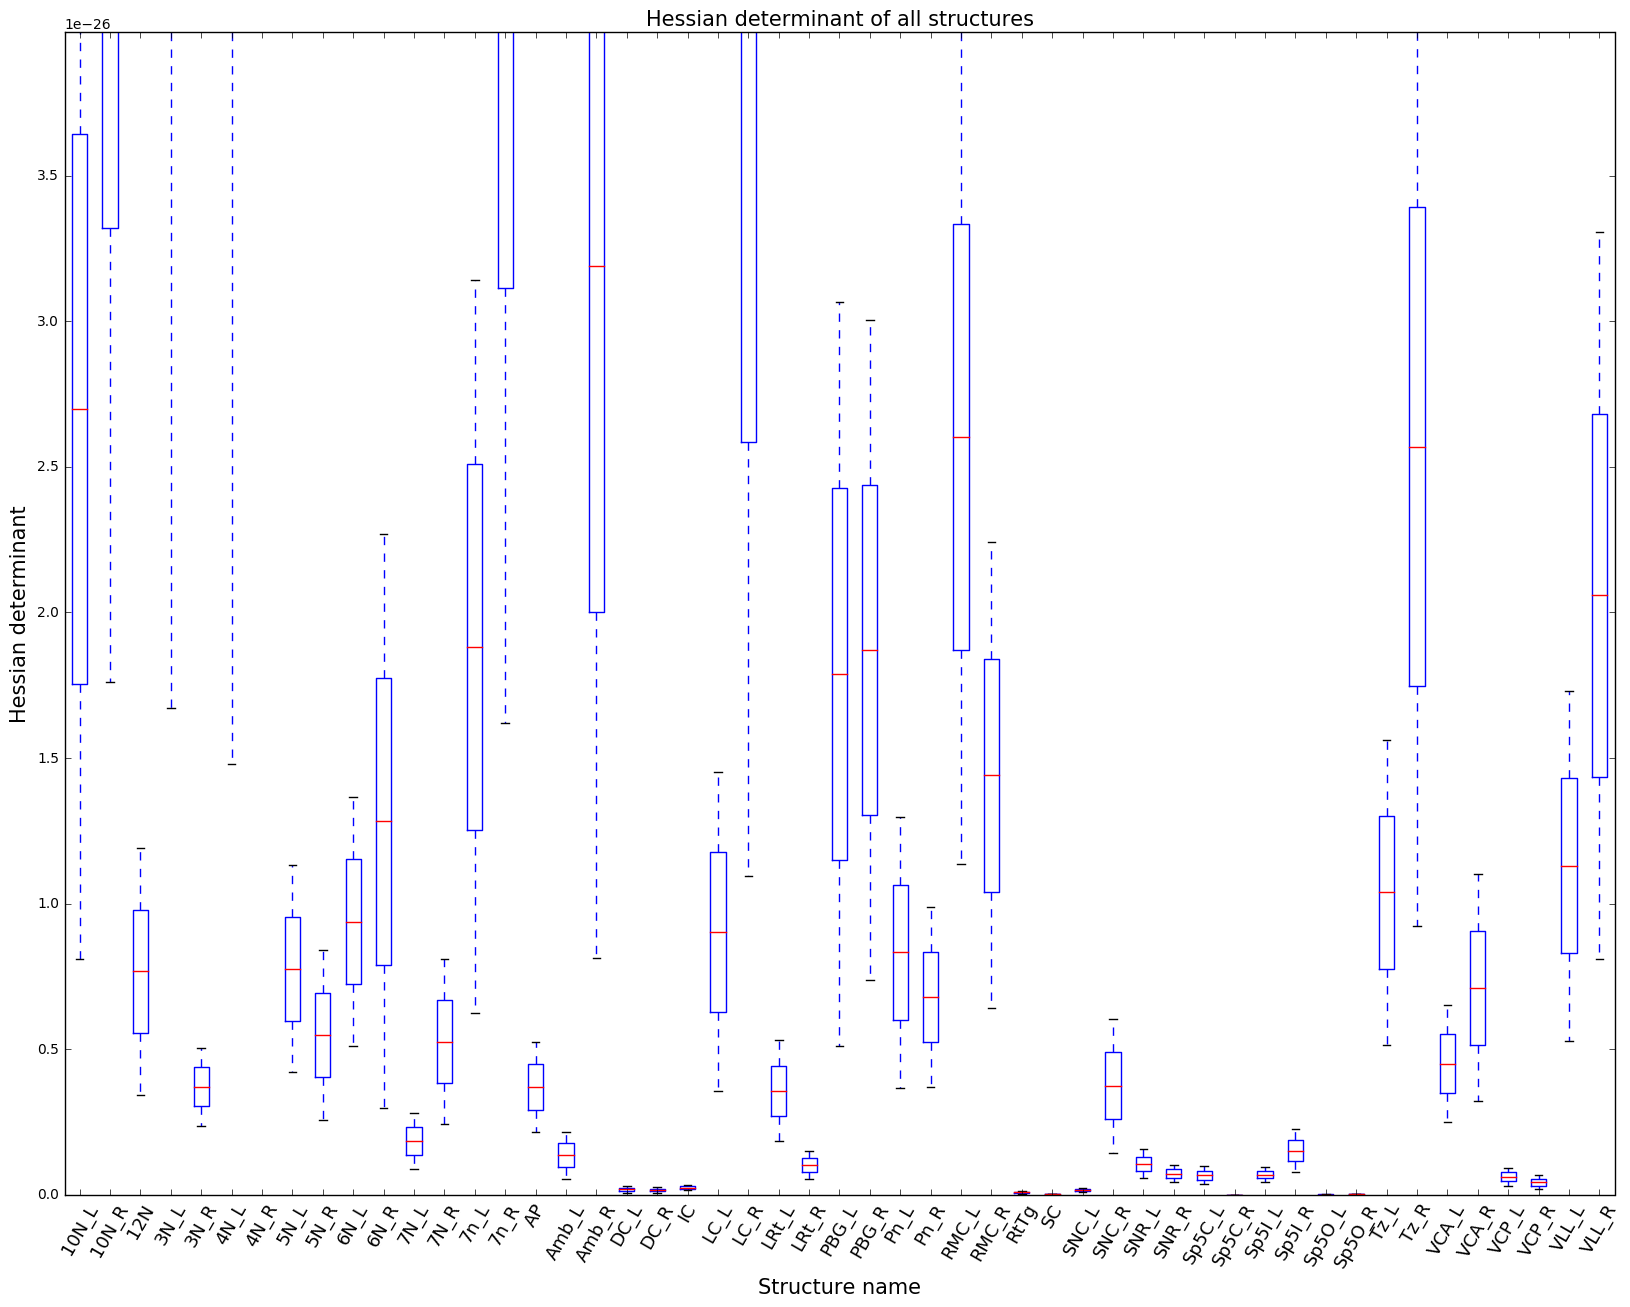

In [135]:
plt.figure(figsize=(20, 15));
plt.boxplot(H);
plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name', fontsize=15);
plt.ylim(0, np.percentile(H, 90));
plt.ylabel('Hessian determinant', fontsize=15);
plt.title('Hessian determinant of all structures', fontsize=15);

# NEW VERSION

# peak radius computed using largest eigenvalue


In [24]:
# peak radius computed using largest eigenvalue

peak_radius_allStructures = {}
zscores_allStructures = {}

for name_s in structures_sided:

        
    hessian_fp = DataManager.get_hessian_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                        moving_volume_type='score', fixed_volume_type='score', 
                                        label=name_s,
                                        train_sample_scheme=train_sample_scheme, 
                                        global_transform_scheme=global_transform_scheme, 
                                        local_transform_scheme=local_transform_scheme)
    
    hessians = load_pickle(hessian_fp)
    
    
    zscore_fp = DataManager.get_zscore_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                        moving_volume_type='score', fixed_volume_type='score', 
                                        label=name_s,
                                        train_sample_scheme=train_sample_scheme, 
                                        global_transform_scheme=global_transform_scheme, 
                                        local_transform_scheme=local_transform_scheme)
    
    zscores = load_pickle(zscore_fp)
    
    zscores_allStructures[name_s] = zscores
    
    ###################################################
        
    peak_radius = {}
        
    for pooling_radius, (zscore, fmax, mu, std) in zscores.iteritems():
        
        peak_radius[pooling_radius] = {}
        
        for step_size, (H, fmax) in hessians.iteritems():
            if pooling_radius > step_size * 2:  # compute only if pooling radius is at least twice the step size
                U, S, UT = np.linalg.svd(H)
                peak_radius[pooling_radius][step_size] = np.sqrt(2*(fmax-mu)/S[0])

    peak_radius_allStructures[name_s] = peak_radius
    

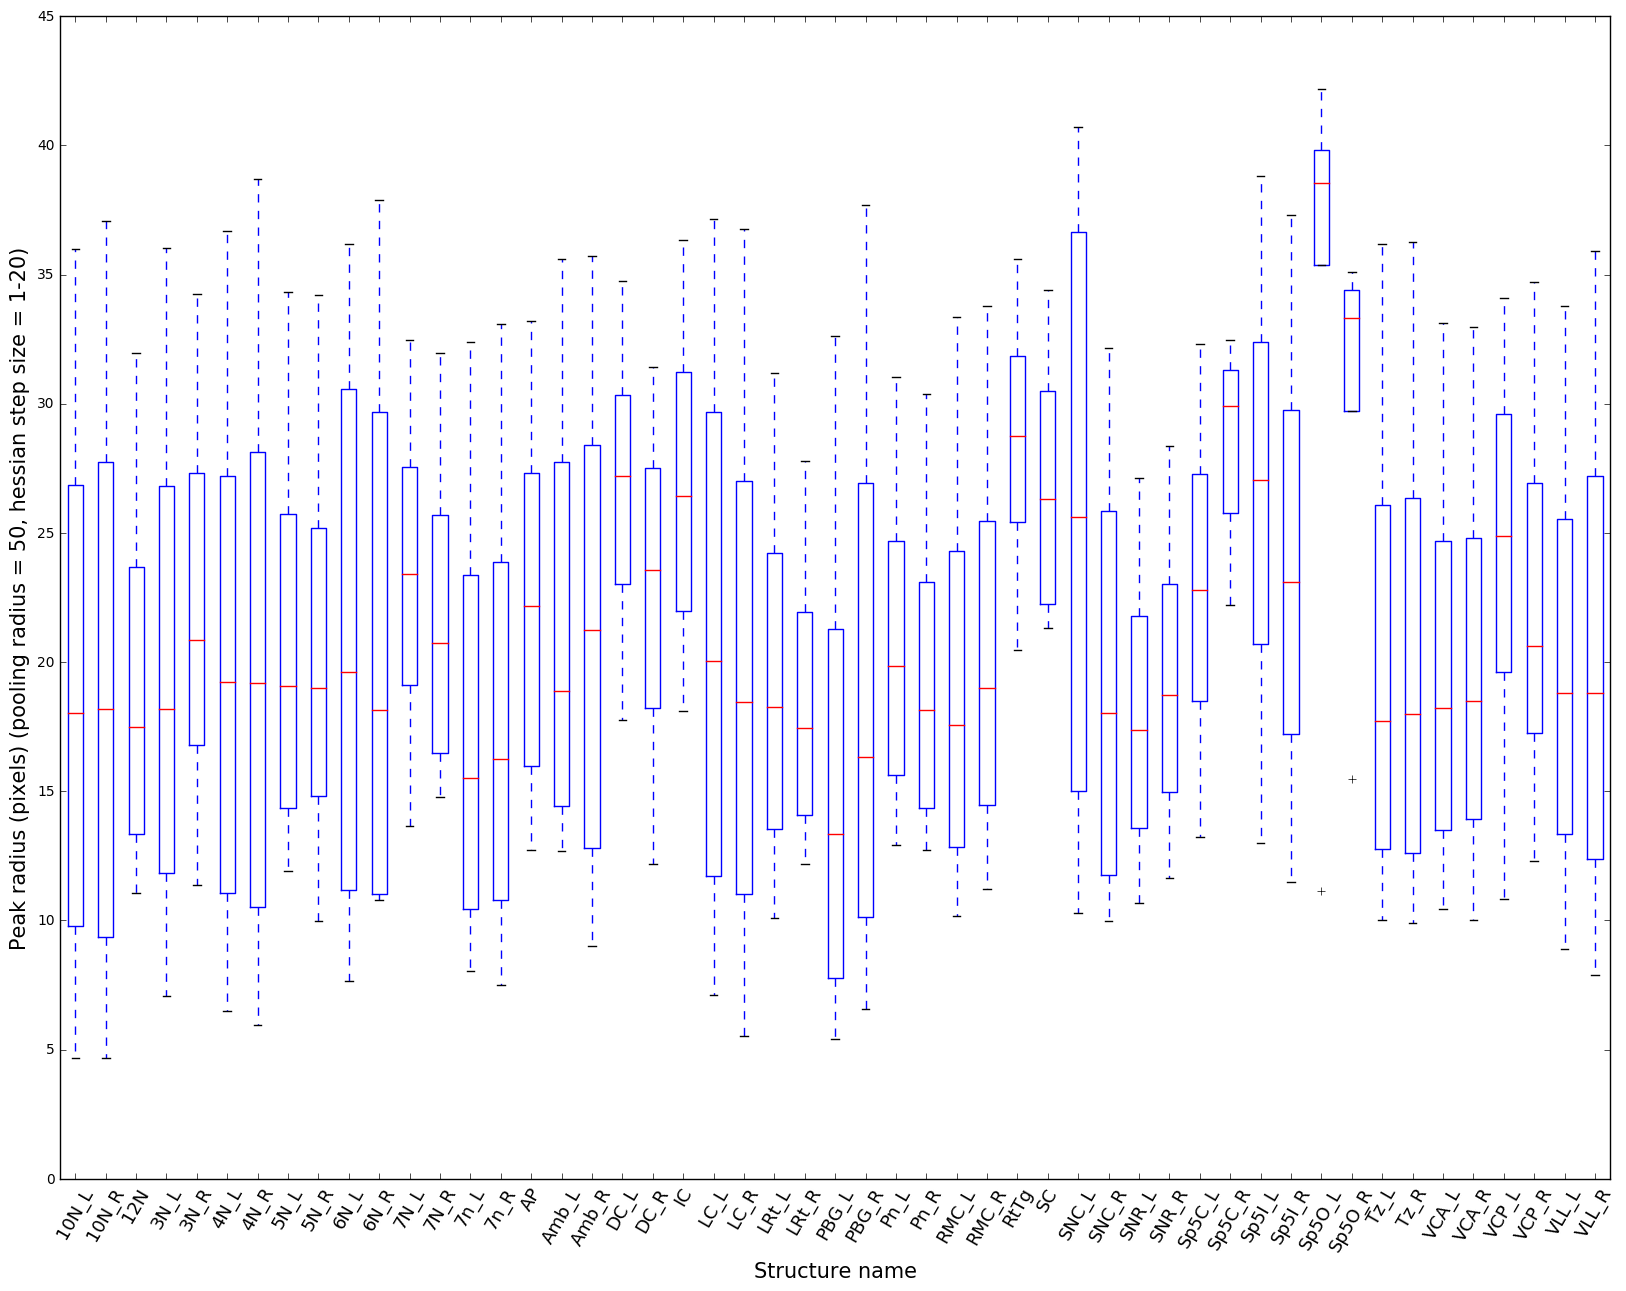

In [25]:
peak_radius_oneCombination = {n: x[50] for n, x in peak_radius_allStructures.iteritems()}
boxplot_labels = [n for n, x in sorted(peak_radius_oneCombination.items())]
D = [x.values() for n, x in sorted(peak_radius_oneCombination.items())]

plt.figure(figsize=(20, 15));
# plt.stem(range(1, len(boxplot_labels)+1), D);
plt.boxplot(D);
# plt.ylim([26, 42]);
plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name', fontsize=15);
plt.ylabel('Peak radius (pixels) (pooling radius = 50, hessian step size = 1-20)', fontsize=15);

# peak radius computed using smallest eigenvalue


In [30]:
# peak radius computed using smallest eigenvalue

peak_radius_allStructures = {}
zscores_allStructures = {}

for name_s in structures_sided:

        
    hessian_fp = DataManager.get_hessian_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                        moving_volume_type='score', fixed_volume_type='score', 
                                        label=name_s,
                                        train_sample_scheme=train_sample_scheme, 
                                        global_transform_scheme=global_transform_scheme, 
                                        local_transform_scheme=local_transform_scheme)
    
    hessians = load_pickle(hessian_fp)
    
    
    zscore_fp = DataManager.get_zscore_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                        moving_volume_type='score', fixed_volume_type='score', 
                                        label=name_s,
                                        train_sample_scheme=train_sample_scheme, 
                                        global_transform_scheme=global_transform_scheme, 
                                        local_transform_scheme=local_transform_scheme)
    
    zscores = load_pickle(zscore_fp)
    
    zscores_allStructures[name_s] = zscores
    
    ###################################################
        
    peak_radius = {}
        
    for pooling_radius, (zscore, fmax, mu, std) in zscores.iteritems():
        
        peak_radius[pooling_radius] = {}
        
        for step_size, (H, fmax) in hessians.iteritems():
            if pooling_radius > step_size * 2:  # compute only if pooling radius is at least twice the step size
                U, S, UT = np.linalg.svd(H)
                peak_radius[pooling_radius][step_size] = np.sqrt(2*(fmax-mu)/S[-1])

    peak_radius_allStructures[name_s] = peak_radius
    

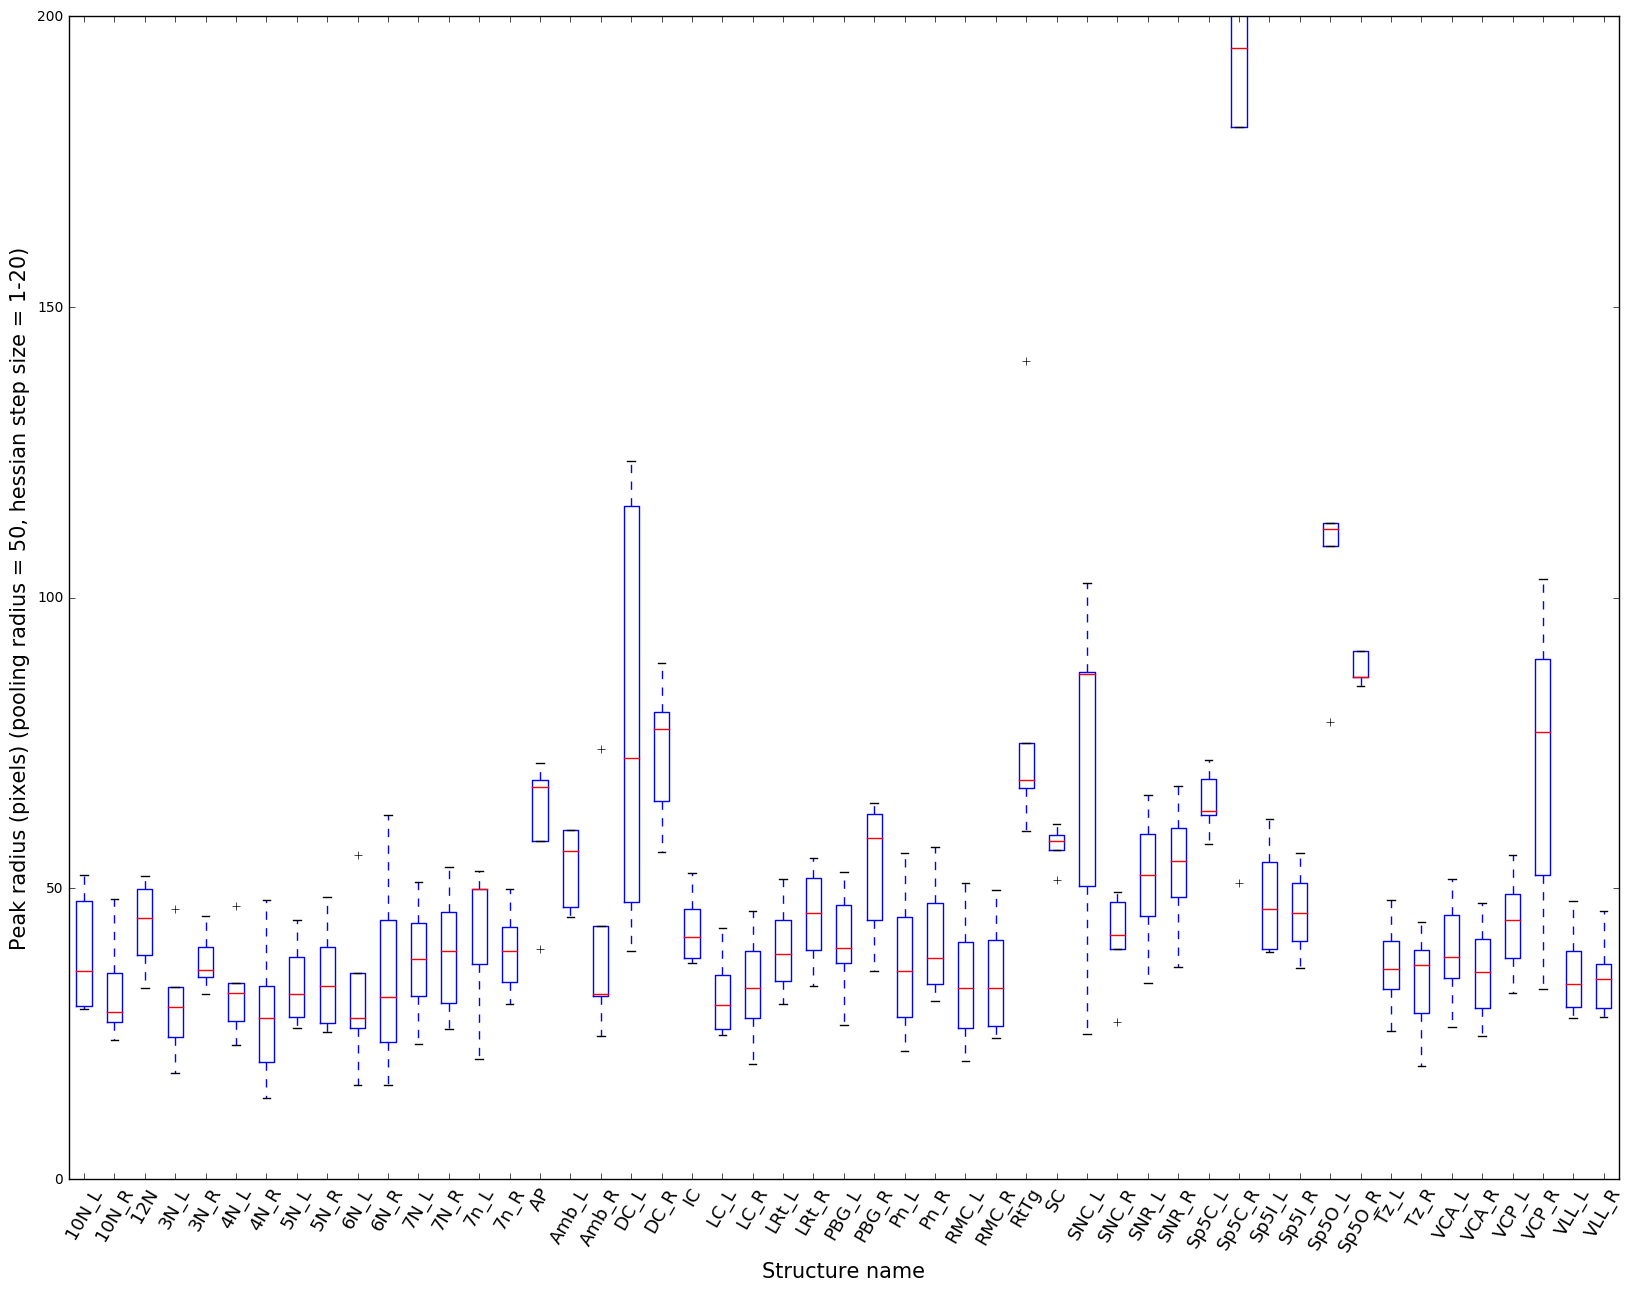

In [34]:
peak_radius_oneCombination = {n: x[50] for n, x in peak_radius_allStructures.iteritems()}
boxplot_labels = [n for n, x in sorted(peak_radius_oneCombination.items())]
D = [x.values() for n, x in sorted(peak_radius_oneCombination.items())]

plt.figure(figsize=(20, 15));
# plt.stem(range(1, len(boxplot_labels)+1), D);
plt.boxplot(D);
plt.ylim([0, 200]);
plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name', fontsize=15);
plt.ylabel('Peak radius (pixels) (pooling radius = 50, hessian step size = 1-20)', fontsize=15);

In [14]:
# dets_allStructures = {}
# zscores_allStructures = {}

# for name_s in structures_sided:
for name_s in ['7N_R']:
    
    if local_transform_scheme == 1 or local_transform_scheme == 2:
    
        aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: 
                                          volume_moving[name_to_label_moving[name_s]]}, \
                           labelIndexMap_m2f={name_to_label_moving[name_s]:
                                              name_to_label_fixed[convert_name_to_unsided(name_s)]})

    elif local_transform_scheme == 3 or local_transform_scheme == 4:
                
        aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: volume_moving[name_to_label_moving[name_s]],
                                         name_to_label_moving[name_s+'_surround']: volume_moving[name_to_label_moving[name_s+'_surround']]}, \
                        labelIndexMap_m2f={name_to_label_moving[name_s]: name_to_label_fixed[convert_name_to_unsided(name_s)],
                                          name_to_label_moving[name_s+'_surround']: name_to_label_fixed[convert_to_original_name(name_s+'_surround')]})

    aligner.set_label_weights(label_weights_m)
    aligner.set_regularization_weights(reg_weights)
        
    # aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
    aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', 
                         indices_m=[name_to_label_moving[name_s]])
    
    ########################################
    
    tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
        DataManager.load_local_alignment_parameters(stack_moving=stack_moving,
                                                    moving_volume_type='score',
                                                    stack_fixed=stack_fixed,
                                                    fixed_volume_type='score',
                                                    train_sample_scheme=train_sample_scheme,
                                                    global_transform_scheme=global_transform_scheme,
                                                    local_transform_scheme=local_transform_scheme,
                                                   label=name_s,
                                                   trial_idx=1)
        
    ###########################################
    
#     def perturb(tx, ty, tz):
#         return aligner.compute_score(tx_params + [0,0,0,tx,0,0,0,ty,0,0,0,tz])

# #     dets = []
#     Hs = []
#     step_sizes = np.linspace(1, 20, 11)

#     for step_size in step_sizes:
#         h = nd.Hessian(lambda (tx, ty, tz): perturb(tx, ty, tz), step=(step_size, step_size, step_size))
#         H = h((0,0,0))
#     #     s, v = np.linalg.eigh(H)
# #         d = np.abs(np.linalg.det(H))
# #         dets.append(d)
#         Hs.append(H)

#     plt.plot(dets);
#     plt.xlabel('step size (pixels)');
#     plt.xticks(range(len(step_sizes)), map(lambda x: '%.2f' % x, step_sizes));
#     plt.ylabel('determinant of Hessian matrix');
#     plt.title('Hessian for different step sizes');
#     plt.show();
    
#     dets_allStructures[name_s] = dets

    ############################################################
    
#     fp = DataManager.get_hessian_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
#                                         moving_volume_type='score', fixed_volume_type='score', 
#                                         label=name_s,
#                                         train_sample_scheme=train_sample_scheme, 
#                                         global_transform_scheme=global_transform_scheme, 
#                                         local_transform_scheme=local_transform_scheme)

#     create_if_not_exists(os.path.dirname(fp))
#     save_pickle(dict(zip(step_sizes, Hs)), fp)
    
    ############################################################

    fmax = aligner.compute_score(tx_params)

#     zscores = []
#     pooling_radius_list = np.linspace(5, 20, 4)

#     for pooling_radius in pooling_radius_list:
        
    pooling_radius = 5

#         print pooling_radius

    n_grid = 10
    neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, 
                                                               dxs=np.linspace(-pooling_radius, pooling_radius, n_grid),
                                                                dys=np.linspace(-pooling_radius, pooling_radius, n_grid),
                                                                dzs=np.linspace(-pooling_radius, pooling_radius, n_grid))
    z = (fmax - np.mean(neighbor_scores)) / np.std(neighbor_scores)

#     zscores.append(z)

#     plt.plot(pooling_radius_list, zscores);
#     plt.xlabel('pooling radius (pixels)');
#     # plt.xticks(range(len(pooling_radius_list)), map(lambda x: '%.2f' % x, pooling_radius_list));
#     plt.ylabel('z-score');
#     plt.title('Z-score for different pooling radius');
#     plt.show();
    
#     zscores_allStructures[name_s] = zscores
    

In [15]:
fmax

0.038657989352941513

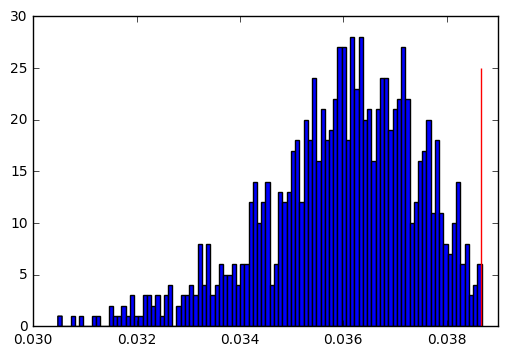

In [16]:
plt.hist(neighbor_scores, bins=100);
plt.vlines(fmax, 0, 25, colors='r');

In [147]:
# dets_allStructures = {}
# zscores_allStructures = {}

# for name_s in structures_sided:
for name_s in ['VLL_R']:
    
    if local_transform_scheme == 1 or local_transform_scheme == 2:
    
        aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: 
                                          volume_moving[name_to_label_moving[name_s]]}, \
                           labelIndexMap_m2f={name_to_label_moving[name_s]:
                                              name_to_label_fixed[convert_name_to_unsided(name_s)]})

    elif local_transform_scheme == 3 or local_transform_scheme == 4:
                
        aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: volume_moving[name_to_label_moving[name_s]],
                                         name_to_label_moving[name_s+'_surround']: volume_moving[name_to_label_moving[name_s+'_surround']]}, \
                        labelIndexMap_m2f={name_to_label_moving[name_s]: name_to_label_fixed[convert_name_to_unsided(name_s)],
                                          name_to_label_moving[name_s+'_surround']: name_to_label_fixed[convert_to_original_name(name_s+'_surround')]})

    aligner.set_label_weights(label_weights_m)
    aligner.set_regularization_weights(reg_weights)
        
    # aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
    aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', 
                         indices_m=[name_to_label_moving[name_s]])
    
    ########################################
    
    tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
        DataManager.load_local_alignment_parameters(stack_moving=stack_moving,
                                                    moving_volume_type='score',
                                                    stack_fixed=stack_fixed,
                                                    fixed_volume_type='score',
                                                    train_sample_scheme=train_sample_scheme,
                                                    global_transform_scheme=global_transform_scheme,
                                                    local_transform_scheme=local_transform_scheme,
                                                   label=name_s,
                                                   trial_idx=1)

    ############################################################

    fmax = aligner.compute_score(tx_params)

    pooling_radius = 5

#         print pooling_radius

    n_grid = 10
    neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, 
                                                               dxs=np.linspace(-pooling_radius, pooling_radius, n_grid),
                                                                dys=np.linspace(-pooling_radius, pooling_radius, n_grid),
                                                                dzs=np.linspace(-pooling_radius, pooling_radius, n_grid))
    z = (fmax - np.mean(neighbor_scores)) / np.std(neighbor_scores)


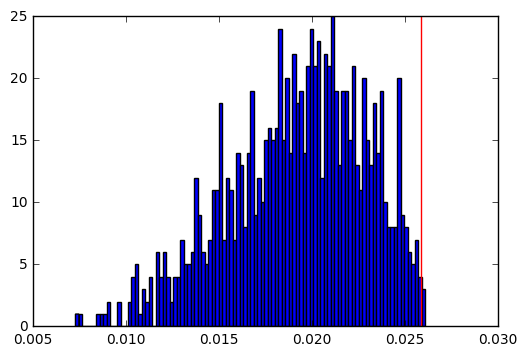

In [148]:
plt.hist(neighbor_scores, bins=100);
plt.vlines(fmax, 0, 25, colors='r');